# Consignes projet 4

**Anticipez les besoins en consommation électrique de bâtiments**
* Lien vers consignes : https://openclassrooms.com/fr/projects/629/assignment
* Lien vers score Star Energy : https://www.energystar.gov/

* Lien vers la signification des colonnes (trouvé via recherche web) : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [121]:
!pip install cython
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 70.9/70.9 MB 21.1 MB/s eta 0:00:00


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

# Chargement jeu de données

In [3]:
data = pd.read_csv('data/data_cleaned_TGE.csv')

In [4]:
d_corr = data.copy()

In [5]:
data.head()

,index,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,GHGEmissionsIntensity,Log2-TotalGHGEmissions
0,0,NonResidential,Hotel,1927,1.0,12,88434,0,88434,88434.0,12000.0,60.0,249.98,2.83,7.971429
1,1,NonResidential,Hotel,1996,1.0,11,103566,15064,88502,83880.0,15064.0,61.0,295.86,2.86,8.213639
2,2,NonResidential,Hotel,1969,1.0,41,956110,196718,759392,756493.0,12000.0,43.0,2089.28,2.19,11.029480
3,3,NonResidential,Hotel,1926,1.0,10,61320,0,61320,61320.0,12000.0,56.0,286.43,4.67,8.167067
4,4,NonResidential,Hotel,1980,1.0,18,175580,62000,113580,123445.0,68009.0,75.0,505.01,2.88,8.983022


In [6]:
data.dtypes

index                              int64  
BuildingType                       object 
PrimaryPropertyType                object 
YearBuilt                          int64  
NumberofBuildings                  float64
NumberofFloors                     int64  
PropertyGFATotal                   int64  
PropertyGFAParking                 int64  
PropertyGFABuilding(s)             int64  
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseTypeGFA    float64
ENERGYSTARScore                    float64
TotalGHGEmissions                  float64
GHGEmissionsIntensity              float64
Log2-TotalGHGEmissions             float64
dtype: object

In [7]:
data.shape

(1544, 15)

In [8]:
# # Liste des colonnes à conserver
# selected_columns = ['BuildingType', 'PrimaryPropertyType', 
#                     'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
#                     'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions','ENERGYSTARScore','Log2-SiteEnergyUseWN(kBtu)']

# # Suppression des colonnes non sélectionnées
# data = data[selected_columns]
# 	index	DataYear	BuildingType	PrimaryPropertyType	CouncilDistrictCode	Neighborhood	YearBuilt	NumberofBuildings	NumberofFloors	PropertyGFATotal	PropertyGFAParking	PropertyGFABuilding(s)	LargestPropertyUseType	LargestPropertyUseTypeGFA	SecondLargestPropertyUseType	SecondLargestPropertyUseTypeGFA	ThirdLargestPropertyUseType	ThirdLargestPropertyUseTypeGFA	ENERGYSTARScore	SiteEnergyUseWN(kBtu)	Outlier	Latitude	Longitude	TotalGHGEmissions	Log2-SiteEnergyUseWN(kBtu)
# index
# DataYear
# BuildingType
# PrimaryPropertyType
# CouncilDistrictCode
# Neighborhood
# YearBuilt
# NumberofBuildings 
# NumberofFloors
# PropertyGFATotal
# PropertyGFAParking
# PropertyGFABuilding(s)
# LargestPropertyUseType
# LargestPropertyUseTypeGFA
# SecondLargestPropertyUseType
# SecondLargestPropertyUseTypeGFA
# ThirdLargestPropertyUseType
# ThirdLargestPropertyUseTypeGFA
# ENERGYSTARScore
# SiteEnergyUseWN(kBtu)
# Outlier
# Latitude
# Longitude
# TotalGHGEmissions
# Log2-SiteEnergyUseWN(kBtu)

In [9]:
data.dtypes

index                              int64  
BuildingType                       object 
PrimaryPropertyType                object 
YearBuilt                          int64  
NumberofBuildings                  float64
NumberofFloors                     int64  
PropertyGFATotal                   int64  
PropertyGFAParking                 int64  
PropertyGFABuilding(s)             int64  
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseTypeGFA    float64
ENERGYSTARScore                    float64
TotalGHGEmissions                  float64
GHGEmissionsIntensity              float64
Log2-TotalGHGEmissions             float64
dtype: object

In [10]:
data.isna().sum().sum()

0

La colonne "ENERGYSTARScore" fait référence au score ENERGY STAR attribué à un bâtiment. ENERGY STAR est un programme international qui évalue et classe l'efficacité énergétique des bâtiments, en leur attribuant un score sur une échelle de 1 à 100. Ce score permet de comparer la performance énergétique d'un bâtiment par rapport à des bâtiments similaires.

Un score ENERGY STAR élevé, proche de 100, indique une efficacité énergétique supérieure, ce qui signifie que le bâtiment consomme moins d'énergie pour fonctionner et a un impact environnemental réduit. Un score plus bas, proche de 1, indique une efficacité énergétique plus faible.

In [11]:
#sauvegarde séparée du energy star score
energy_star_score = data['ENERGYSTARScore']
data.drop('ENERGYSTARScore', axis=1, inplace=True)

In [12]:
data.shape

(1544, 14)

In [13]:
data.isna().sum().sum()

0

In [14]:
data.head()

,index,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,TotalGHGEmissions,GHGEmissionsIntensity,Log2-TotalGHGEmissions
0,0,NonResidential,Hotel,1927,1.0,12,88434,0,88434,88434.0,12000.0,249.98,2.83,7.971429
1,1,NonResidential,Hotel,1996,1.0,11,103566,15064,88502,83880.0,15064.0,295.86,2.86,8.213639
2,2,NonResidential,Hotel,1969,1.0,41,956110,196718,759392,756493.0,12000.0,2089.28,2.19,11.029480
3,3,NonResidential,Hotel,1926,1.0,10,61320,0,61320,61320.0,12000.0,286.43,4.67,8.167067
4,4,NonResidential,Hotel,1980,1.0,18,175580,62000,113580,123445.0,68009.0,505.01,2.88,8.983022


# Préparation des vecteurs et matrices

## Séparation X et y 

La colonne "SiteEnergyUseWN(kBtu)" fait référence à la consommation d'énergie totale du site, mesurée en kilo British Thermal Units (kBtu). Cette mesure représente la quantité totale d'énergie utilisée par un bâtiment sur une période donnée, généralement sur une base annuelle.

In [16]:
# # y = data.copy()[{'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions' , 'Log2-SiteEnergyUseWN(kBtu)'}]
# # X = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'], axis=1)
# # Sélection des colonnes 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'
# # pour créer le DataFrame y contenant ces colonnes
# y = data.copy()[{'Log2-TotalGHGEmissions)'}] #1 variable a expliquer, ou la cible 
# # y = data.copy()[{'SiteEnergyUseWN(kBtu)'}] #1 variable a expliquer, ou la cible 

# # Création du DataFrame X en faisant une copie de data et en supprimant les colonnes 
# # 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'
# X = data.copy().drop(['TotalGHGEmissions', 'Log2-TotalGHGEmissions'], axis=1) 
# plusieurs variable qui explique Y 
y = data.copy()[{'Log2-TotalGHGEmissions'}] #1 variable a expliquer, ou la cible 
# y = data.copy()[{'SiteEnergyUseWN(kBtu)'}] #1 variable a expliquer, ou la cible 

# Création du DataFrame X en faisant une copie de data et en supprimant les colonnes 
# 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'
# X = data.copy().drop([ 'TotalGHGEmissions', 'Log2-TotalGHGEmissions','Log2-SiteEnergyUseWN(kBtu)','SiteEnergyUseWN(kBtu)'], axis=1) 
# plusieurs variable qui explique Y 
X = data.copy().drop([ 'TotalGHGEmissions', 'Log2-TotalGHGEmissions'], axis=1)

## Normalisation & One Hot Encoder 

In [17]:
X.select_dtypes(['category','object']).nunique()

BuildingType           3 
PrimaryPropertyType    22
dtype: int64

In [18]:
X.shape

(1544, 12)

In [19]:
categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(['int8','int64','int32','float32','float64']).columns

In [20]:
categorical_columns

Index(['BuildingType', 'PrimaryPropertyType'], dtype='object')

In [21]:
numerical_columns

Index(['index', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'GHGEmissionsIntensity'],
      dtype='object')

In [22]:
numerical_columns_y = y.select_dtypes(['int8','int64','int32','float32','float64']).columns
numerical_columns_y

Index(['Log2-TotalGHGEmissions'], dtype='object')

In [23]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ohe = OneHotEncoder(sparse=False)
# ss = StandardScaler()
# X[numerical_columns] = ss.fit_transform(X[numerical_columns])
# ohe.fit_transform(X[categorical_columns])

# X = pd.merge(X[numerical_columns], 
#           pd.DataFrame(columns = ohe.get_feature_names().tolist(),
#               data = ohe.fit_transform(X[categorical_columns])),
#         left_index = True, right_index = True)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Instanciation de l'encodeur OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Instanciation du StandardScaler
ss = StandardScaler()

# Standardisation des colonnes numériques dans X à l'aide de StandardScaler
X[numerical_columns] = ss.fit_transform(X[numerical_columns])

# Encodage One-Hot des colonnes catégorielles dans X à l'aide de OneHotEncoder
ohe.fit_transform(X[categorical_columns])

# Fusion des colonnes numériques standardisées avec les colonnes catégorielles encodées
# en utilisant pd.merge pour combiner les DataFrames
X = pd.merge(X[numerical_columns],
             pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                          data=ohe.fit_transform(X[categorical_columns])),
             left_index=True, right_index=True)


Transformation des types des catégories sorties du one hot encoding

In [24]:
# import re
# regex = re.compile(r'x\d_')
# for column in X.columns:
#     if regex.search(column):
#         X[column] = X[column].astype('int32')
import re

# Compilation de l'expression régulière
regex = re.compile(r'x\d_')

# Parcours de chaque colonne dans X
for column in X.columns:
    # Vérification si la colonne correspond au motif de l'expression régulière
    if regex.search(column):
        # Conversion de la colonne en type 'int32'
        X[column] = X[column].astype('int32')


In [25]:
X.sample(5)

,index,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,GHGEmissionsIntensity,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Laboratory,x1_Large Office,x1_Low-Rise Multifamily,x1_Medical Office,x1_Mixed Use Property,x1_Office,x1_Other,x1_Refrigerated Warehouse,x1_Residence Hall,x1_Restaurant,x1_Retail Store,x1_Self-Storage Facility,x1_Senior Care Community,x1_Small- and Mid-Sized Office,x1_Supermarket / Grocery Store,x1_University,x1_Warehouse,x1_Worship Facility
548,-0.742995,0.143629,-0.063737,-0.336866,0.057976,-0.316789,0.148257,0.142129,-0.010167,-0.704848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
262,-1.034127,0.538767,-0.063737,0.252673,-0.120707,-0.316789,-0.055153,-0.031915,-0.495512,-0.544072,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
700,-0.327661,0.022048,-0.063737,-0.484251,-0.452820,-0.316789,-0.433226,-0.413126,-0.495512,4.482874,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
900,0.133380,-0.129928,-0.063737,-0.336866,-0.479022,-0.316789,-0.463054,-0.449948,-0.257140,-0.774518,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
101,-1.223909,-1.740876,-0.063737,-0.042096,0.012540,-0.316789,0.096534,0.153753,-0.257140,-0.469043,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Infos sur X et y

In [26]:
X.shape

(1544, 35)

In [27]:
y.shape

(1544, 1)

In [28]:
y

,Log2-TotalGHGEmissions
0,7.971429
1,8.213639
2,11.029480
3,8.167067
4,8.983022
...,...
1539,4.455492
1540,5.051807
1541,7.810829
1542,4.530445


# Séparation jeu de données

**Séparation test / train**

In [29]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = \
#                         train_test_split(X, 
#                                          y['Log2-SiteEnergyUseWN(kBtu)'],  
#                                          test_size = 0.2, 
#                                          random_state = 42
#                                         )
from sklearn.model_selection import train_test_split

# Division des données en ensembles d'entraînement et de test
# avec 80% des données pour l'ensemble d'entraînement et 20% pour l'ensemble de test
# Les variables explicatives sont stockées dans X et la variable cible est y['Log2-SiteEnergyUseWN(kBtu)']
# random_state est utilisé pour garantir la reproductibilité des résultats
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y['Log2-TotalGHGEmissions'],  
                                                    test_size=0.2, 
                                                    random_state=42)


In [30]:
X_train.shape

(1235, 35)

In [31]:
X_test.shape

(309, 35)

In [32]:
y_train.shape

(1235,)

In [33]:
y_test.shape

(309,)

In [34]:
results = pd.DataFrame({})

In [35]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(y_train.isna().sum().sum())
print(y_test.isna().sum().sum())


0
0
0
0


# Modélisation

**Imports**

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## Linear Regression / Ridge Regression / Lasso / Elastic Net

Le modèle Elastic Net comprend les modèles linéaires / ridge et lasso via les valeurs des coefficients dans le grid search CV

In [37]:
#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

# Importation de la classe ElasticNet depuis la bibliothèque sklearn.linear_model
from sklearn.linear_model import ElasticNet

# Définition des paramètres pour la recherche sur grille
parameters = {'tol' : [0.1,0.01,0.001,0.0001],  # Tolérance de la convergence de l'algorithme #alpha, coef qui multiplie le terme de pénalité)
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Paramètre alpha (termes de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}  # Ratio de mélange entre les termes L1 et L2 #L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

# Création de l'estimateur ElasticNet et de la grille de recherche sur les paramètres
elastic_grid = GridSearchCV(estimator=ElasticNet(),
                      param_grid=parameters,
                      scoring='neg_mean_squared_error',  # Métrique de performance à optimiser
                      cv=5,  # Nombre de folds pour la validation croisée
                      verbose=0)

# Recherche des meilleurs paramètres sur la grille en utilisant les données d'entraînement
elastic_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

Cette commande qui permet d'afficher les meilleurs paramètres choisis par la méthode de recherche par grille (GridSearchCV) pour un modèle de régression aléatoire (ElasticNet).

In [38]:
elastic_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.0, 'tol': 0.1}

{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.001}

Le modèle optimal a les caractéristiques suivantes:
* alpha = 0.001 : le terme de régularisation Lasso (L1) est quasiment nul mais il ne s'agit pas de notre paramètre le plus faible dasn le grid search CV
* le terme l1_ratio est approximativement de 0.4, signifiant que le poids du L1 est plus important que celui du L2 dans la régularisation 

In [39]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
              ignore_index=True)

ils existent plusieurs métriques différentes pour évaluer, 5 exemples :

- R2 (Coefficient de détermination)
- MAE (erreur absolue moyenne)
- RMSE (erreur quadratique moyenne)
- MPSE (erreur quadratique moyenne en pourcentage)
- Taux de prédictions entre 90 et 110 % de la valeur réelle

- Coefficient de détermination (R²) : C'est le score qui mesure la proportion de la variance de la variable cible (y) expliquée par les variables explicatives (X) du modèle. Plus le R² est proche de 1, meilleur est le modèle.

- Erreur absolue moyenne (MAE) : C'est la moyenne des écarts absolus entre les valeurs prédites et les valeurs réelles. Elle mesure la magnitude moyenne de l'erreur sans tenir compte de sa direction.

- Erreur quadratique moyenne (RMSE) : C'est la racine carrée de la moyenne des écarts quadratiques entre les valeurs prédites et les valeurs réelles. Elle mesure la dispersion des erreurs et est plus sensible aux valeurs aberrantes que la MAE.

- Erreur quadratique moyenne en pourcentage (MPSE) : C'est le RMSE normalisé en pourcentage par rapport à la moyenne des valeurs réelles. Il permet de comparer l'erreur du modèle par rapport à l'échelle des valeurs réelles.

- Taux de prédictions entre 90% et 110% de la valeur réelle : C'est le pourcentage des prédictions qui se situent dans une fourchette de ±10% par rapport aux valeurs réelles. Il mesure la précision du modèle dans la prédiction des valeurs proches de la réalité.

In [40]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Prédiction sur les données de test
y_pred_test = elastic_grid.predict(X_test)

# Calcul du coefficient de détermination (R²)
r2 = r2_score(y_test, y_pred_test)
print("R² :", r2)

# Calcul de l'erreur absolue moyenne (MAE)
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE :", mae)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE :", rmse)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test.mean() * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((y_pred_test >= 0.9 * y_test) & (y_pred_test <= 1.1 * y_test)).mean() * 100
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)


R² : 0.5454513054693093
MAE : 0.9249614578101346
RMSE : 1.4115346434126574
MPSE : 25.038488428210005
Taux de prédictions entre 90% et 110% : 43.689320388349515


In [41]:
# Calcul du RMSE
y_pred_test = elastic_grid.predict(X_test)
rmse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test)))
print("RMSE (exp):", rmse)

# Calcul du MAP
map_score = mean_absolute_percentage_error(np.exp2(y_test), np.exp2(y_pred_test))
print("MAPE (exp) :", map_score)

# Calcul du R²
r2 = r2_score(np.exp2(y_test), np.exp2(y_pred_test))
print("R² (exp) :", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test))) / np.exp2(y_test.mean()) * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((np.exp2(y_pred_test) >= 0.9 * np.exp2(y_test)) & (np.exp2(y_pred_test) <= 1.1 * np.exp2(y_test))).mean() * 100 
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)


RMSE (exp): 10682.6678083411
MAPE (exp) : 28.633759016401687
R² (exp) : -183.33464908760962
MPSE : 21460.276645265654
Taux de prédictions entre 90% et 110% : 11.326860841423949


## Random Forest Regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

In [43]:
rfr_search = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.6s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.9s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   2.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.9s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.9s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.9s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.8s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [44]:
rfr_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}

<!-- {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300} -->
{'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 300}

Cette commande qui permet d'afficher les meilleurs paramètres choisis par la méthode de recherche par grille (GridSearchCV) pour un modèle de régression aléatoire (RandomForestRegressor).

Plus précisément, la méthode best_params_ de l'objet rfr_search renvoie un dictionnaire de paramètres avec leurs valeurs correspondantes, qui ont donné la meilleure performance lors de la validation croisée. Dans votre cas, les paramètres suivants ont été sélectionnés comme les meilleurs :

- max_features: Cette option détermine le nombre maximum de fonctionnalités à utiliser pour chaque arbre de décision dans la forêt aléatoire. Ici, la valeur "sqrt" est choisie, ce qui signifie que le nombre de fonctionnalités sera égal à la racine carrée du nombre total de fonctionnalités dans l'ensemble de données.
- min_samples_leaf: Cet hyperparamètre est le nombre minimum d'échantillons requis pour être au niveau de la feuille d'un arbre de décision. Une valeur de 3 a été choisie ici, ce qui signifie qu'un nœud doit avoir au moins 3 échantillons pour être considéré comme une feuille.
- n_estimators: Cet hyperparamètre détermine le nombre d'arbres dans la forêt aléatoire. Ici, une valeur de 300 a été choisie.
En utilisant ces paramètres pour entraîner le modèle de régression aléatoire, vous devriez obtenir la meilleure performance possible.

In [45]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# seuil = 1
# # Calcul du RMSE
# y_pred_test = rfr_search.predict(X_test)
# rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
# print("RMSE:", rmse)

# # Conversion des valeurs réelles erfr_searchn classe binaire
# y_true_class = np.where(y_test > seuil, 1, 0)  # Remplacez le seuil par la valeur appropriée

# # Calcul du MAP
# map_score = average_precision_score(y_true_class, y_pred_test)
# print("MAP:", map_score)

# # Calcul du R²
# r2 = r2_score(y_test, y_pred_test)
# print("R²:", r2)

# Calcul du RMSE
y_pred_test = rfr_search.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE(log):", rmse)

# Calcul du MAPE
map_score = mean_absolute_percentage_error(y_test, y_pred_test)
print("MAPE(log):", map_score)

# Calcul du R²
r2 = r2_score(y_test, y_pred_test)
print("R²(log):", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test.mean() * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((y_pred_test >= 0.9 * y_test) & (y_pred_test <= 1.1 * y_test)).mean() * 100
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)

# # Calcul du RMSE
# y_pred_test = rfr_search.predict(X_test)
# rmse = math.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))
# print("RMSE:", rmse)

# # Calcul du MAP
# map_score = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test))
# print("MAPE:", map_score)

# # Calcul du R²
# r2 = r2_score(np.exp(y_test), np.exp(y_pred_test))
# print("R²:", r2)


RMSE(log): 0.6994630779207958
MAPE(log): 144144782231364.97
R²(log): 0.8883838801330617
MPSE : 12.407416469876882
Taux de prédictions entre 90% et 110% : 93.85113268608414


In [46]:
# Calcul du RMSE
y_pred_test = rfr_search.predict(X_test)
rmse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test)))
print("RMSE (exp):", rmse)

# Calcul du MAP
map_score = mean_absolute_percentage_error(np.exp2(y_test), np.exp2(y_pred_test))
print("MAPE (exp) :", map_score)

# Calcul du R²
r2 = r2_score(np.exp2(y_test), np.exp2(y_pred_test))
print("R² (exp) :", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test))) / np.exp2(y_test.mean()) * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((np.exp2(y_pred_test) >= 0.9 * np.exp2(y_test)) & (np.exp2(y_pred_test) <= 1.1 * np.exp2(y_test))).mean() * 100 
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)


RMSE (exp): 396.0876542225233
MAPE (exp) : 3.2209001218063262
R² (exp) : 0.7465862701050423
MPSE : 795.6954936624256
Taux de prédictions entre 90% et 110% : 74.75728155339806


In [878]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(rfr_search.predict(X_test), y_test))]}),
              ignore_index=True)

In [879]:
coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

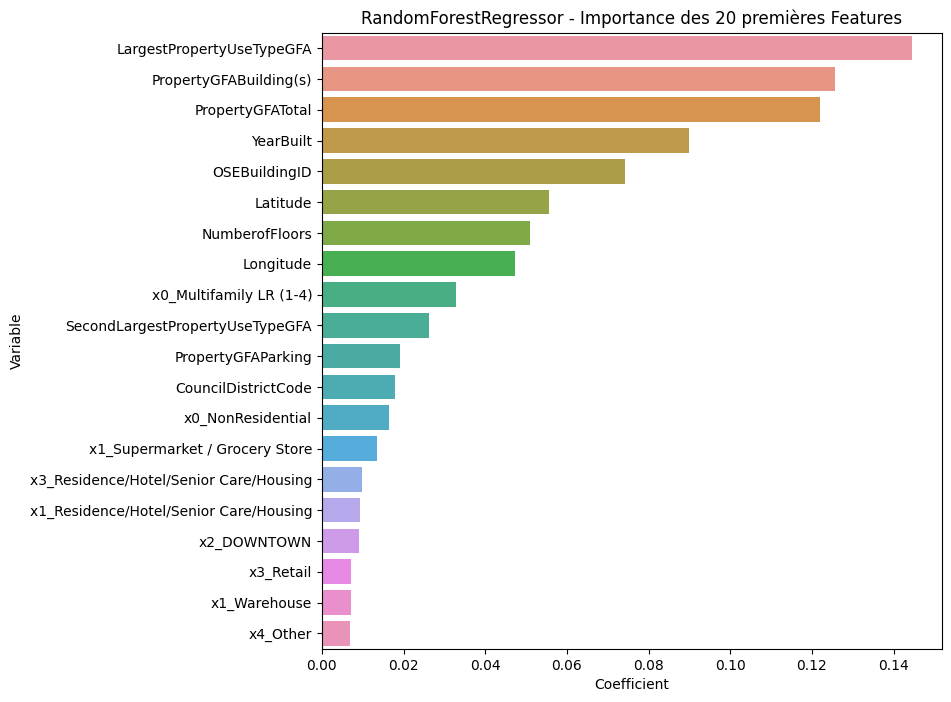

In [880]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

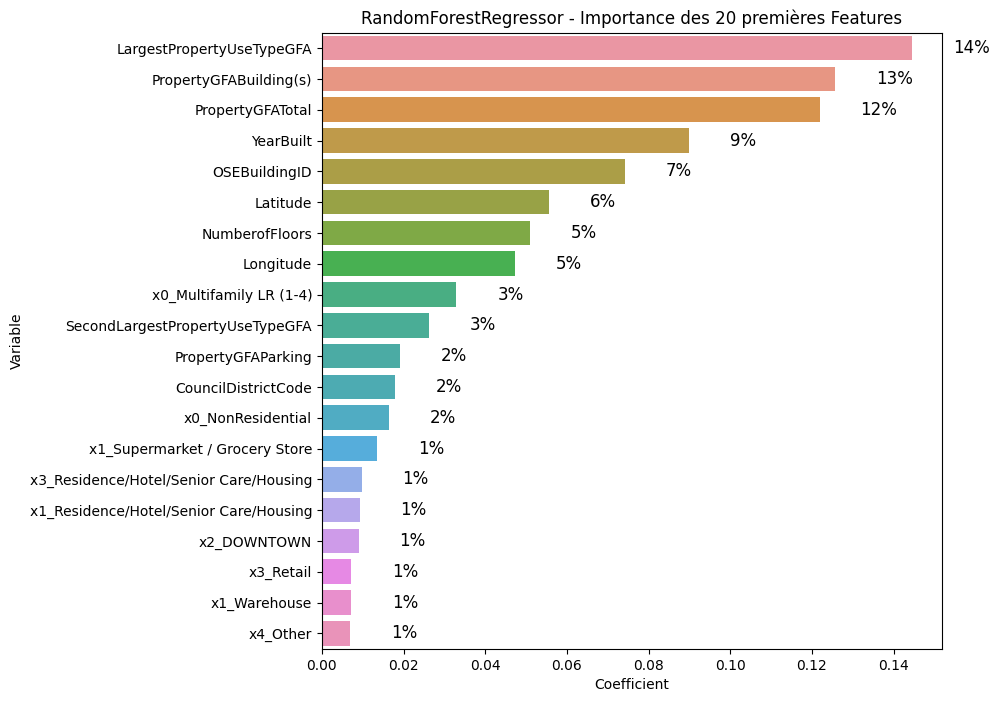

In [882]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')

# Créer le graphique à barres
barplot = sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))

# Parcourir toutes les barres et ajouter les pourcentages correspondants
for p in barplot.patches:
    width = p.get_width()    # Récupérer la largeur de la barre
    percentage = width * 100    # Calculer le pourcentage
    plt.text(width + 0.01,    # Ajouter un petit décalage
             p.get_y() + p.get_height() / 2,    # Récupérer la hauteur de la barre
             f'{percentage:.0f}%',    # Afficher le pourcentage sans décimale
             ha='left',    # Aligner à gauche
             va='center',    # Centrer verticalement
             fontsize=12)    # Taille de la police


plt.show()


## Support Vector Regression 

In [883]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      #scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-08; total time=   0.2s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-08; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-08; total time=   0.2s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-08; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-08; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-07; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-07; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-07; total time=   0.2s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-07; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-07; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.001, gamma=1e-06; total time=   0.1s
[CV] END ................C=0.001, epsilon=0.00

[CV] END .................C=0.001, epsilon=0.1, gamma=0.0001; total time=   0.1s
[CV] END .................C=0.001, epsilon=0.1, gamma=0.0001; total time=   0.1s
[CV] END .................C=0.001, epsilon=0.1, gamma=0.0001; total time=   0.1s
[CV] END .................C=0.001, epsilon=0.1, gamma=0.0001; total time=   0.1s
[CV] END ..................C=0.001, epsilon=0.1, gamma=0.001; total time=   0.1s
[CV] END ..................C=0.001, epsilon=0.1, gamma=0.001; total time=   0.1s
[CV] END ..................C=0.001, epsilon=0.1, gamma=0.001; total time=   0.1s
[CV] END ..................C=0.001, epsilon=0.1, gamma=0.001; total time=   0.1s
[CV] END ..................C=0.001, epsilon=0.1, gamma=0.001; total time=   0.1s
[CV] END ...................C=0.001, epsilon=0.1, gamma=0.01; total time=   0.1s
[CV] END ...................C=0.001, epsilon=0.1, gamma=0.01; total time=   0.1s
[CV] END ...................C=0.001, epsilon=0.1, gamma=0.01; total time=   0.1s
[CV] END ...................

[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-08; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-08; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-07; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-07; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-07; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-07; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-07; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-06; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-06; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-06; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-06; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, gamma=1e-06; total time=   0.1s
[CV] END ..................C

[CV] END .....................C=0.01, epsilon=1, gamma=0.001; total time=   0.1s
[CV] END .....................C=0.01, epsilon=1, gamma=0.001; total time=   0.1s
[CV] END .....................C=0.01, epsilon=1, gamma=0.001; total time=   0.1s
[CV] END .....................C=0.01, epsilon=1, gamma=0.001; total time=   0.1s
[CV] END ......................C=0.01, epsilon=1, gamma=0.01; total time=   0.1s
[CV] END ......................C=0.01, epsilon=1, gamma=0.01; total time=   0.1s
[CV] END ......................C=0.01, epsilon=1, gamma=0.01; total time=   0.1s
[CV] END ......................C=0.01, epsilon=1, gamma=0.01; total time=   0.1s
[CV] END ......................C=0.01, epsilon=1, gamma=0.01; total time=   0.1s
[CV] END .......................C=0.01, epsilon=1, gamma=0.1; total time=   0.1s
[CV] END .......................C=0.01, epsilon=1, gamma=0.1; total time=   0.1s
[CV] END .......................C=0.01, epsilon=1, gamma=0.1; total time=   0.1s
[CV] END ...................

[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-07; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-07; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-06; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-06; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-06; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-06; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-06; total time=   0.2s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-05; total time=   0.2s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-05; total time=   0.2s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-05; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-05; total time=   0.1s
[CV] END ....................C=0.1, epsilon=0.1, gamma=1e-05; total time=   0.1s
[CV] END ...................

[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.1s
[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.2s
[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.2s
[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.2s
[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.2s
[CV] END ......................C=1, epsilon=0.001, gamma=0.1; total time=   0.2s
[CV] END ......................C=1, epsilon=0.001, gamma=0.1; total time=   0.1s
[CV] END ......................C=1, epsilon=0.001, gamma=0.1; total time=   0.2s
[CV] END ......................C=1, epsilon=0.001, gamma=0.1; total time=   0.2s
[CV] END ......................C=1, epsilon=0.001, gamma=0.1; total time=   0.2s
[CV] END .....................C=1, epsilon=0.01, gamma=1e-08; total time=   0.2s
[CV] END .....................C=1, epsilon=0.01, gamma=1e-08; total time=   0.2s
[CV] END ...................

[CV] END ........................C=1, epsilon=1, gamma=1e-06; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-06; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-05; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-05; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-05; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-05; total time=   0.1s
[CV] END ........................C=1, epsilon=1, gamma=1e-05; total time=   0.1s
[CV] END .......................C=1, epsilon=1, gamma=0.0001; total time=   0.0s
[CV] END .......................C=1, epsilon=1, gamma=0.0001; total time=   0.1s
[CV] END .......................C=1, epsilon=1, gamma=0.0001; total time=   0.0s
[CV] END .......................C=1, epsilon=1, gamma=0.0001; total time=   0.0s
[CV] END .......................C=1, epsilon=1, gamma=0.0001; total time=   0.1s
[CV] END ...................

[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s
[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.2s
[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s
[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s
[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-08; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-08; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-08; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-08; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-08; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-07; total time=   0.1s
[CV] END .....................C=10, epsilon=0.1, gamma=1e-07; total time=   0.1s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             verbose=2)

In [884]:
svm.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 0.01}

{'C': 10, 'epsilon': 1, 'gamma': 0.01}

In [885]:
results = results.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),
              ignore_index=True)

In [886]:
results

,Modèle,Score_RMSE
0,Elasticnet Regression,1.318084
1,Random Forest Regressor,1.182000
2,Support Vector Machine,1.225538


In [887]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
 # Calcul du RMSE
y_pred_test = svm.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE(log):", rmse)

# Calcul du MAP
map_score = mean_absolute_percentage_error(y_test, y_pred_test)
print("MAPE(log):", map_score)

# Calcul du R²
r2 = r2_score(y_test, y_pred_test)
print("R²(log):", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test.mean() * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((y_pred_test >= 0.9 * y_test) & (y_pred_test <= 1.1 * y_test)).mean() * 100
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)

# # Calcul du RMSE
# y_pred_test = svm.predict(X_test)
# rmse = math.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))
# print("RMSE:", rmse)

# # Calcul du MAP
# map_score = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test))
# print("MAPE:", map_score)

# # Calcul du R²
# r2 = r2_score(np.exp(y_test), np.exp(y_pred_test))
# print("R²:", r2)


RMSE(log): 1.2255384690056026
MAPE(log): 0.2669067930232945
R²(log): 0.5535881147985504
MPSE : 25.4200422956223
Taux de prédictions entre 90% et 110% : 24.485125858123567


In [888]:
# Calcul du RMSE
y_pred_test = svm.predict(X_test)
rmse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test)))
print("RMSE (exp):", rmse)

# Calcul du MAP
map_score = mean_absolute_percentage_error(np.exp2(y_test), np.exp2(y_pred_test))
print("MAPE (exp) :", map_score)

# Calcul du R²
r2 = r2_score(np.exp2(y_test), np.exp2(y_pred_test))
print("R² (exp) :", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test))) / np.exp2(y_test.mean()) * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((np.exp2(y_pred_test) >= 0.9 * np.exp2(y_test)) & (np.exp2(y_pred_test) <= 1.1 * np.exp2(y_test))).mean() * 100 
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)


RMSE (exp): 78.67317488638295
MAPE (exp) : 0.8832853737662509
R² (exp) : 0.3550725741516908
MPSE : 278.30165870582186
Taux de prédictions entre 90% et 110% : 5.720823798627003


## XG Boost 

In [889]:
from xgboost import XGBRegressor

In [890]:
parameters = {
    'n_estimators' : [100,500,1000,2000]
}
xgb_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                        param_grid = parameters,
                      #scoring = 'neg_mean_squared_error',
                        cv = 5,
                        verbose=5)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................n_estimators=100;, score=0.531 total time=   0.2s
[CV 2/5] END ..................n_estimators=100;, score=0.588 total time=   0.2s
[CV 3/5] END ..................n_estimators=100;, score=0.529 total time=   0.2s
[CV 4/5] END ..................n_estimators=100;, score=0.509 total time=   0.2s
[CV 5/5] END ..................n_estimators=100;, score=0.544 total time=   0.2s
[CV 1/5] END ..................n_estimators=500;, score=0.519 total time=   1.4s
[CV 2/5] END ..................n_estimators=500;, score=0.576 total time=   1.3s
[CV 3/5] END ..................n_estimators=500;, score=0.521 total time=   1.3s
[CV 4/5] END ..................n_estimators=500;, score=0.499 total time=   1.3s
[CV 5/5] END ..................n_estimators=500;, score=0.541 total time=   1.3s
[CV 1/5] END .................n_estimators=1000;, score=0.519 total time=   2.0s
[CV 2/5] END .................n_estimators=1000;,

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
 

In [891]:
xgb_grid.best_params_

{'n_estimators': 100}

In [892]:
xgb_grid.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [893]:
xgb_grid.best_estimator_.feature_importances_

array([0.00382193, 0.        , 0.00300521, 0.00613629, 0.00572332,
       0.01929979, 0.00432787, 0.00753994, 0.01951972, 0.00681247,
       0.01863532, 0.06199252, 0.00352748, 0.00175022, 0.        ,
       0.00307714, 0.12791729, 0.01016525, 0.0151764 , 0.00565815,
       0.00678719, 0.03103763, 0.0080477 , 0.00741715, 0.00539223,
       0.        , 0.01427367, 0.0028335 , 0.02036472, 0.01178395,
       0.00744353, 0.08965859, 0.02080026, 0.        , 0.00614663,
       0.0286238 , 0.02118106, 0.00462835, 0.00910598, 0.00690605,
       0.0075342 , 0.00839758, 0.0154792 , 0.00321246, 0.00287481,
       0.00807097, 0.        , 0.00545573, 0.        , 0.        ,
       0.01053718, 0.00199181, 0.00436722, 0.        , 0.03185666,
       0.15591747, 0.02614917, 0.        , 0.        , 0.        ,
       0.00461212, 0.00939998, 0.00233589, 0.01083342, 0.01023947,
       0.        , 0.00855806, 0.00211869, 0.        , 0.        ,
       0.        , 0.        , 0.01120099, 0.03233863, 0.     

In [894]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['XGBoost'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(xgb_grid.predict(X_test), y_test))]}),
              ignore_index=True)

In [895]:
results

,Modèle,Score_RMSE
0,Elasticnet Regression,1.318084
1,Random Forest Regressor,1.182000
2,Support Vector Machine,1.225538
3,XGBoost,1.249208


In [899]:
import math
results_exp = results.append(pd.DataFrame({
    'Modèle': ['XGBoost'],
    'Score_RMSE': [math.sqrt(mean_squared_error(xgb_grid.predict(X_test), np.exp2(y_test)))],
}), ignore_index=True)


In [900]:
results_exp

,Modèle,Score_RMSE
0,Elasticnet Regression,1.318084
1,Random Forest Regressor,1.182000
2,Support Vector Machine,1.225538
3,XGBoost,1.249208
4,XGBoost,112.598738


In [901]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
 # Calcul du RMSE
y_pred_test = xgb_grid.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE(log):", rmse)

# Calcul du MAPE
map_score = mean_absolute_percentage_error(y_test, y_pred_test)
print("MAPE(log):", map_score)

# Calcul du R²
r2 = r2_score(y_test, y_pred_test)
print("R²(log):", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test.mean() * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((y_pred_test >= 0.9 * y_test) & (y_pred_test <= 1.1 * y_test)).mean() * 100
print("Taux de prédictions entre 90% et 110% :", predictions_within_range) 

RMSE(log): 1.249208388873304
MAPE(log): 0.24319315648372267
R²(log): 0.536177687832667
MPSE : 25.911002293523605
Taux de prédictions entre 90% et 110% : 33.18077803203661


In [902]:
# Calcul du RMSE
y_pred_test = xgb_grid.predict(X_test)
rmse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test)))
print("RMSE (exp):", rmse)

# Calcul du MAP
map_score = mean_absolute_percentage_error(np.exp2(y_test), np.exp2(y_pred_test))
print("MAPE (exp) :", map_score)

# Calcul du R²
r2 = r2_score(np.exp2(y_test), np.exp2(y_pred_test))
print("R² (exp) :", r2)

# Calcul de l'erreur quadratique moyenne en pourcentage (MPSE)
mpse = math.sqrt(mean_squared_error(np.exp2(y_test), np.exp2(y_pred_test))) / np.exp2(y_test.mean()) * 100
print("MPSE :", mpse)

# Calcul du taux de prédictions entre 90% et 110% de la valeur réelle
predictions_within_range = ((np.exp2(y_pred_test) >= 0.9 * np.exp2(y_test)) & (np.exp2(y_pred_test) <= 1.1 * np.exp2(y_test))).mean() * 100 
print("Taux de prédictions entre 90% et 110% :", predictions_within_range)

RMSE (exp): 75.35097439227955
MAPE (exp) : 0.9895166207342047
R² (exp) : 0.40839036538584017
MPSE : 266.5495728214335
Taux de prédictions entre 90% et 110% : 10.526315789473683


## Export des modèles pour réutilisation ultérieure

In [903]:
rfr_search

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [904]:
dict_modeles = {
    'Elastic Net': elastic_grid.best_estimator_,
    'Random Forest Regressor' : rfr_search.best_estimator_,
    'SVM' : svm.best_estimator_,
    'XGBoost' : xgb_grid.best_estimator_,
}

In [905]:
import pickle
for nom, model in dict_modeles.items():
    filename = 'models/' + nom + '.obj' 
    with  open(filename, 'wb') as filehandler :
        pickle.dump(model, filehandler)

In [906]:
#Export du one hot encoder

with  open('models/onehotencoder.obj', 'wb') as filehandler :
    pickle.dump(ohe, filehandler)
    
#export du standardscaler
with  open('models/standardscaler.obj', 'wb') as filehandler :
    pickle.dump(ss, filehandler)

## Chargement des modèles

In [907]:
dict_modeles_new = dict_modeles

In [908]:
dict_modeles_new = {}

In [909]:
import glob
import pickle
for filename in glob.glob('models/*'):
    if filename not in ['models\onehotencoder.obj', 'models\standardscaler.obj']:
        with open(filename, 'rb') as filehandler:
            print(filename)
            dict_modeles_new[str(filename)] = pickle.load(filehandler)

models\Elastic Net.obj
models\Random Forest Regressor.obj
models\rfr_emissions.obj
models\SVM.obj
models\XGBoost.obj


In [910]:
dict_modeles_new['models\XGBoost.obj'].feature_importances_

array([0.00382193, 0.        , 0.00300521, 0.00613629, 0.00572332,
       0.01929979, 0.00432787, 0.00753994, 0.01951972, 0.00681247,
       0.01863532, 0.06199252, 0.00352748, 0.00175022, 0.        ,
       0.00307714, 0.12791729, 0.01016525, 0.0151764 , 0.00565815,
       0.00678719, 0.03103763, 0.0080477 , 0.00741715, 0.00539223,
       0.        , 0.01427367, 0.0028335 , 0.02036472, 0.01178395,
       0.00744353, 0.08965859, 0.02080026, 0.        , 0.00614663,
       0.0286238 , 0.02118106, 0.00462835, 0.00910598, 0.00690605,
       0.0075342 , 0.00839758, 0.0154792 , 0.00321246, 0.00287481,
       0.00807097, 0.        , 0.00545573, 0.        , 0.        ,
       0.01053718, 0.00199181, 0.00436722, 0.        , 0.03185666,
       0.15591747, 0.02614917, 0.        , 0.        , 0.        ,
       0.00461212, 0.00939998, 0.00233589, 0.01083342, 0.01023947,
       0.        , 0.00855806, 0.00211869, 0.        , 0.        ,
       0.        , 0.        , 0.01120099, 0.03233863, 0.     

## Comparaison des modèles

Comparons les modèles sur le critère de la RMSE divisée par la moyenne de la valeur à prédire

In [911]:
results['RMSE_%'] = results['Score_RMSE'].divide(y_test.mean())

In [912]:
results 

,Modèle,Score_RMSE,RMSE_%
0,Elasticnet Regression,1.318084,0.273396
1,Random Forest Regressor,1.182000,0.245170
2,Support Vector Machine,1.225538,0.254200
3,XGBoost,1.249208,0.259110


La RMSE relative des meilleurs modèles est de 3,0 % (racine de l'erreur quadratique moyenne ramenée à la valeur à prédire), c'est une performance remarquable.

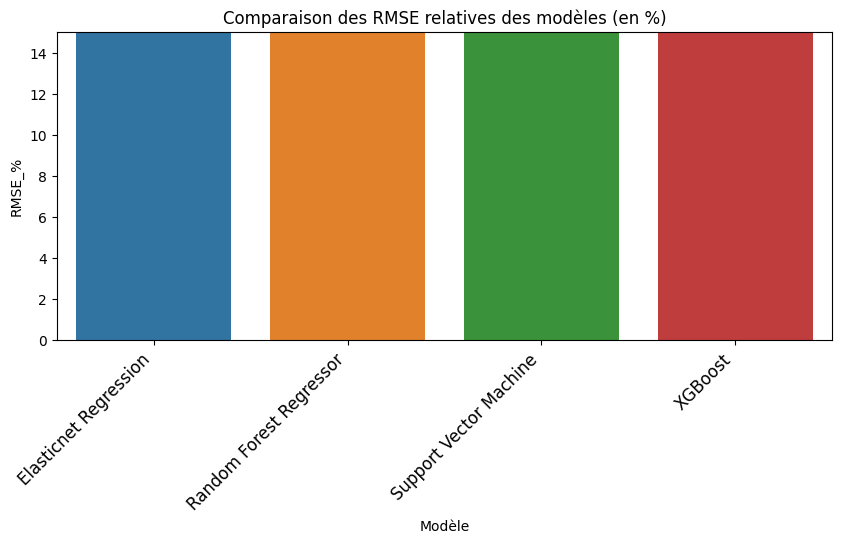

In [913]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE relatives des modèles (en %)')
chart = sns.barplot(x = results['Modèle'],
           y = results['RMSE_%']*100)
chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 15])
plt.show()

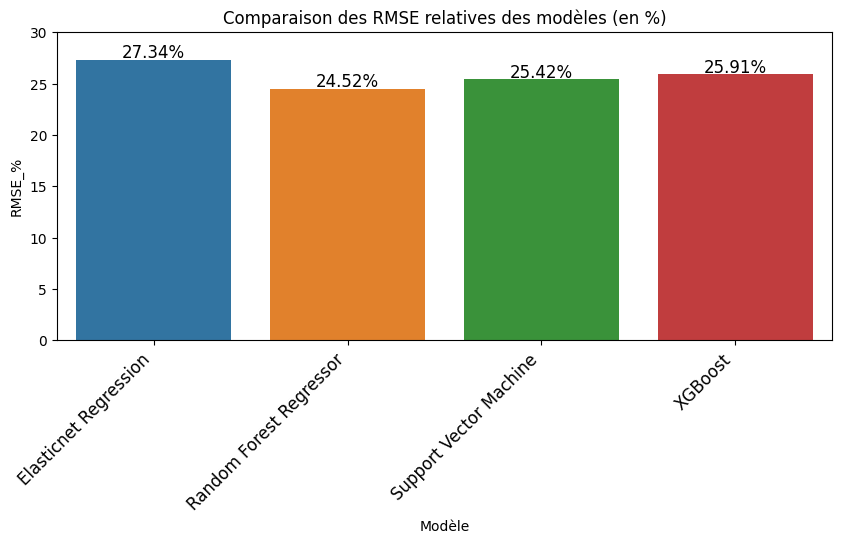

In [915]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE relatives des modèles (en %)')
chart = sns.barplot(x=results['Modèle'], y=results['RMSE_%']*100)

# Ajouter les pourcentages au dessus de chaque barre
for i in range(len(results)):
    plt.text(x=i, y=results['RMSE_%'][i]*100+0.2, 
             s=f"{results['RMSE_%'][i]*100:.2f}%", 
             horizontalalignment='center', size=12)

chart.set_xticklabels(labels=results['Modèle'], rotation=45, 
                      horizontalalignment='right', size=12)
ax = plt.gca()
ax.set_ylim([0, 30])
plt.show()


Support Vector Machine et Elasticnet Regression sont les modèles avec la plus faible RMSE, avec une valeur très proche.

Regardons quel algorithme est entraîné le plus rapidement et prédit le plus rapidement, pour voir lequel sélectionner pour les étapes suivantes

Comparaison avec la RMSE pour un estimateur donnant la valeur moyenne

In [916]:
math.sqrt(mean_squared_error(y_train.mean()*np.ones(y_test.shape[0]), y_test))

1.8379035445710985

In [917]:
rfr_search.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=300)

le modèle Random Forest semble plus rapide à entraîner

In [918]:
list(dict_modeles.keys())

['Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost']

In [919]:
list(dict_modeles_new.keys())

['models\\Elastic Net.obj',
 'models\\Random Forest Regressor.obj',
 'models\\rfr_emissions.obj',
 'models\\SVM.obj',
 'models\\XGBoost.obj']

In [920]:
dict_modeles.update(dict_modeles_new)
print(dict_modeles)
list(dict_modeles.keys())

{'Elastic Net': ElasticNet(alpha=0.0001, l1_ratio=0.9, tol=0.001), 'Random Forest Regressor': RandomForestRegressor(max_features='sqrt', n_estimators=300), 'SVM': SVR(C=10, epsilon=1, gamma=0.01), 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...), 'models\\Elastic Net.obj': ElasticNet(alpha=0.0001, 

['Elastic Net',
 'Random Forest Regressor',
 'SVM',
 'XGBoost',
 'models\\Elastic Net.obj',
 'models\\Random Forest Regressor.obj',
 'models\\rfr_emissions.obj',
 'models\\SVM.obj',
 'models\\XGBoost.obj']

In [921]:
print(y_test.dtypes)

float64


In [922]:
print(X_test)

      OSEBuildingID  DataYear  CouncilDistrictCode  Latitude  Longitude  \
282  -1.845578       0.0       1.251985            -0.088167 -1.043295    
367  -0.193257       0.0      -1.633858            -1.133772 -1.902604    
514  -0.139067       0.0      -1.152884            -1.671435  2.234041    
605  -0.103524       0.0      -1.152884            -1.269902 -0.222392    
508  -0.141693       0.0       1.251985            -0.189589 -0.016704    
2045  1.688168       0.0       0.290038             2.137303 -0.507474    
1106  0.134511       0.0       0.290038             2.107791  1.481084    
552  -0.127949       0.0      -0.190936             1.267940  1.283152    
1242  0.188526       0.0       0.290038             1.464134 -0.744550    
2011  0.620472       0.0       0.290038             1.751150  0.542012    
1865  0.478474       0.0      -1.152884            -1.437831  1.812696    
96   -1.881909       0.0      -1.633858            -1.101766 -2.045883    
2152  2.472482       0.0 

In [923]:
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

math.sqrt(mean_squared_error(y_test, modele.predict(X_test)))

ValueError: Feature shape mismatch, expected: 77, got 75

In [924]:
from sklearn.metrics import r2_score, mean_absolute_error


nom_modeles = ['Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost']
liste_modeles = [dict_modeles['models\\Elastic Net.obj'],
                 dict_modeles['models\\Random Forest Regressor.obj'],
                 dict_modeles['models\\SVM.obj'],
                 dict_modeles['models\\XGBoost.obj']
                ]

comparaison_score = pd.DataFrame(index = nom_modeles, columns = ['RMSE', 'R2', 'RMSE_relative'])

for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_score.loc[nom_modele, 'RMSE'] = math.sqrt(mean_squared_error(y_test, modele.predict(X_test)))
    comparaison_score.loc[nom_modele, 'R2'] = r2_score(y_test, modele.predict(X_test))

#normalisation RMSE
comparaison_score['RMSE_relative'] = comparaison_score['RMSE'].divide(comparaison_score['RMSE'].max())

In [925]:
comparaison_score

,RMSE,R2,RMSE_relative
Elastic Net,1.318084,0.483621,1.0
Random Forest Regressor,1.182,0.584743,0.896756
SVM,1.225538,0.553588,0.929788
XGBoost,1.249208,0.536178,0.947745


In [926]:
# i=0
# for modele in liste_modeles:
#     print(nom_modeles[i], ': ')
#     i+=1
#     %timeit modele.predict(X_train)
#     print('')

In [927]:
# plt.title('Temps d\'exécution des algorithmes pour la prédiction \n(jeu d\'entrainement)')
# sns.barplot(x=nom_modeles,
#            y = [1.61, 95.5, 83, 10])
# ax = plt.gca()
# ax.set_yscale('log')

Elastic Net : 
3.04 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Random Forest Regressor : 
152 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SVM : 
222 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

XGBoost : 
7.06 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



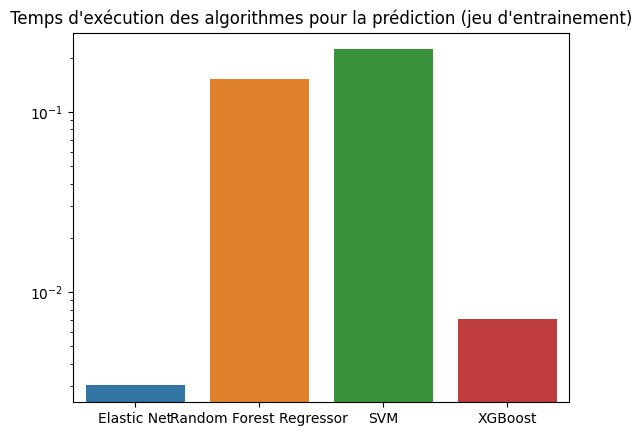

In [928]:
result = []
i = 0
for modele in liste_modeles:
    print(nom_modeles[i], ': ')
    i += 1
    time = %timeit -r 1 -n 1 -o modele.predict(X_train)
    result.append(time.best)
    print('')
plt.title('Temps d\'exécution des algorithmes pour la prédiction (jeu d\'entrainement)')
sns.barplot(x=nom_modeles, y=result)
ax = plt.gca()
ax.set_yscale('log')


le temps d'exécution de XGBoost est plus faible que celui de random forest (4 fois plus faible), ce pourrait être un critère pour choisir éventuellement le XGBoost plutôt que le Random Forest Regressor (quite à dégrader légèrement la performance)

In [929]:
comparaison_score_melt = pd.melt(comparaison_score.reset_index(), id_vars = ['index'], value_name = 'score', value_vars=['R2', 'RMSE_relative'])

Text(0.5, 1.0, 'Comparaison des performances des modèles (jeu de test)')

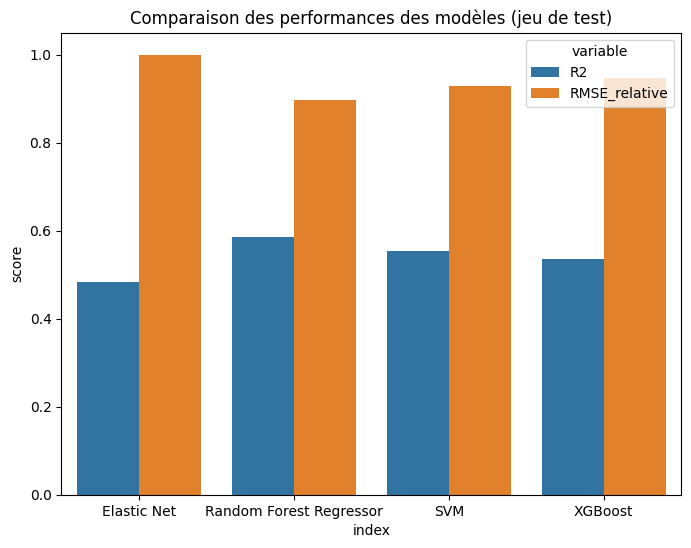

In [930]:
plt.figure(figsize=(8,6))
sns.barplot(x = comparaison_score_melt['index'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'])
plt.title('Comparaison des performances des modèles (jeu de test)')

# Vérification des prédictions

Regardons avec un exemple ce que donne la prédiction

In [931]:
X_extrait = X_test
y_extrait = y_test

In [932]:
X_extrait.head()

,OSEBuildingID,DataYear,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,x0_Campus,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Education,x1_Facility,x1_Health,x1_Leisure,x1_Office,x1_Offices,x1_Other,x1_Residence/Hotel/Senior Care/Housing,x1_Retail,x1_Storage,x1_Supermarket / Grocery Store,x1_Warehouse,x2_BALLARD,x2_CENTRAL,x2_DELRIDGE,x2_DOWNTOWN,x2_EAST,x2_GREATER DUWAMISH,x2_LAKE UNION,x2_MAGNOLIA / QUEEN ANNE,x2_NORTH,x2_NORTHEAST,x2_NORTHWEST,x2_SOUTHEAST,x2_SOUTHWEST,x3_Education,x3_Facility,x3_Health,x3_Leisure,x3_Office,x3_Offices,x3_Other,x3_Parking,x3_Residence/Hotel/Senior Care/Housing,x3_Retail,x3_Storage,x4_Education,x4_Facility,x4_Health,x4_Leisure,x4_Office,x4_Offices,x4_Other,x4_Parking,x4_Residence/Hotel/Senior Care/Housing,x4_Retail,x4_Storage,x5_Facility,x5_Office,x5_Other,x5_Retail,x6_High Outlier,x6_Low Outlier,x6_Normal
282,-1.845578,0.0,1.251985,-0.088167,-1.043295,0.984174,-0.035639,0.115391,0.912338,2.042505,0.433582,0.535150,1.750055,-0.03396,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
367,-0.193257,0.0,-1.633858,-1.133772,-1.902604,0.671765,-0.035639,-0.329470,-0.466800,0.181814,-0.603160,-0.571767,0.078099,-0.03396,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
514,-0.139067,0.0,-1.152884,-1.671435,2.234041,-0.234221,-0.035639,-0.329470,-0.342421,-0.235028,-0.327947,-0.286564,-0.349939,-0.03396,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
605,-0.103524,0.0,-1.152884,-1.269902,-0.222392,-0.421666,-0.035639,-0.774331,-0.526793,-0.235028,-0.543858,-0.414546,-0.349939,-0.03396,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
508,-0.141693,0.0,1.251985,-0.189589,-0.016704,0.827969,-0.035639,-0.329470,-0.568047,-0.235028,-0.592170,-0.560378,-0.349939,-0.03396,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [933]:
y_extrait.head()

282    5.801676
367    2.367371
514    3.516015
605    1.432959
508    2.904966
Name: Log2-TotalGHGEmissions, dtype: float64

In [934]:
prediction = dict_modeles['Random Forest Regressor'].predict(X_extrait)

Ramenons la prédiction à l'unité qu'on cherche à prédire (inverse du log2(y+1) soit exp2(y)-1

In [935]:
pd.DataFrame(prediction).isna().sum()

0    0
dtype: int64

In [936]:
type(y_extrait)

pandas.core.series.Series

In [937]:
predictions = pd.DataFrame([y_extrait, 
                            pd.Series(prediction, index = y_extrait.index),
                           np.exp2(y_extrait)-1,
                           np.exp2(pd.Series(prediction, index = y_extrait.index))-1]).T
predictions.columns = ['y_log', 'y_predict_log', 'y','y_predict']
# predictions.columns = [ 'y','y_predict','y_log', 'y_predict_log']

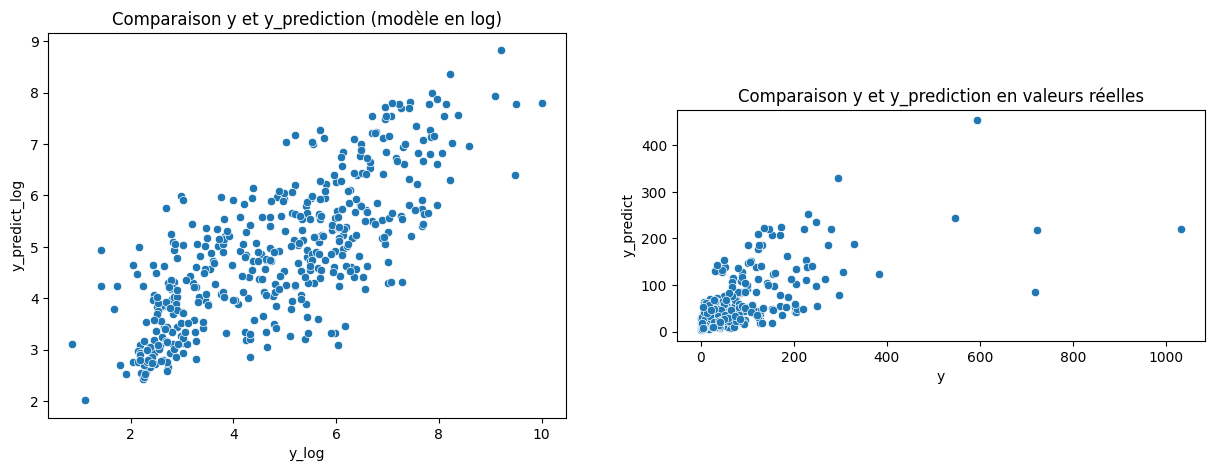

In [938]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=False)
sns.scatterplot(x = predictions['y_log'],
               y = predictions['y_predict_log'],
               ax = ax1)
sns.scatterplot(x = predictions['y'],
               y = predictions['y_predict'],
               ax=ax2)
ax1.set_aspect('equal', 'box')

ax2.set_aspect('equal', 'box')

ax1.title.set_text('Comparaison y et y_prediction (modèle en log)')
ax2.title.set_text('Comparaison y et y_prediction en valeurs réelles')
# ax2.title.set_text('Comparaison y et y_prediction (modèle en log)')
# ax1.title.set_text('Comparaison y et y_prediction en valeurs réelles')


# Pertinence des variables

## Permutations des variables

Les permutations aléatoires sont utilisées pour mélanger les données, évaluer les performances des modèles de manière impartiale

Afin de voir si toutes les features ont de l'influence sur nos resultats, essayons de voir l'influence sur notre métrique dans le cas de permutations des features et d'application de notre modèle de prédiction.

3 fonctions ont été testées. La dernière (permutation finale) est la plus pertinente.

Updates:
- permutation par ligne dans le one hot encoding (et non par colonne)
- utilisation du jeu de validation et non le jeu de  test
- mean squared error comme metrics
- cross validation à 3

In [939]:
X_train.shape

(1747, 75)

In [940]:
X_test.shape

(437, 75)

- Les importations nécessaires sont effectuées, y compris le filtrage des avertissements futurs.
- Une liste vide text_columns est créée pour stocker les noms des colonnes correspondant aux vraies features avant la transformation One-Hot Encoding (OHE).
- Les préfixes des colonnes liées à l'application de l'OHE sont stockés dans une liste prefixes, et les indices des colonnes sont stockés dans la liste index_cols.
- Un dictionnaire dict_OHE est créé pour associer chaque préfixe à une liste de colonnes correspondantes.
- Les noms des colonnes correspondant aux vraies features sont ajoutés à la liste text_columns, et leurs indices sont ajoutés à la liste index_cols.
- Les données sont divisées en ensembles d'entraînement et de validation à l'aide de la fonction train_test_split.
- Une boucle est effectuée pour chaque feature.
- Un modèle de régression aléatoire est créé.
- Pour chaque feature, une permutation est effectuée sur les colonnes correspondantes en utilisant la fonction np.random.permutation.
- Le modèle est entraîné sur les données permises, et le score est calculé à l'aide de la validation croisée.
- La feature ayant le score RMSE le plus élevé est identifiée et supprimée.
- Les informations sur la feature supprimée et son score sont affichées.
- Les index des colonnes à supprimer sont identifiés et mis à jour.
- Les colonnes correspondantes sont supprimées des ensembles d'entraînement et de validation.
- La boucle se répète jusqu'à ce que toutes les features aient été évaluées.
- Un DataFrame features_score est créé pour stocker les noms des features et leurs scores RMSE.
- Les informations sur les features supprimées et les colonnes correspondantes sont affichées.

Le code suivant, permet de déterminer l'importance de chaque feature dans un modèle en effectuant des permutations sur les colonnes et en évaluant l'impact sur le score RMSE. Cela permet d'identifier les features les moins importantes et de les supprimer pour améliorer la performance du modèle.


In [941]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import cross_val_score

#on créee un dictionnaire pour les colonnes crées par le OHE, pour les retrouver dans l'application des permutations
text_columns =[] #les noms des colonnes qui correspondent à des vraies features (pré OHE)
prefixes = [] #les préfixes des colonnes liées à l'application du OHE
index_cols = [] #les indices des colonnes qui correspondent aux features pré OHE et à la première colonne de chaque feature du OHE
regex = re.compile(r'x\d_')
for j, column in enumerate(X.columns):
    if regex.search(column):
        if column[:2] not in prefixes:
            prefixes.append(column[:2])
            index_cols.append(j)
    else:
        text_columns.append(column)
        index_cols.append(j)
        
dict_OHE = {}
for prefix in prefixes:
    temp_list = []
    for column in X.columns:
        if prefix in column:
            temp_list.append(column)
    dict_OHE[prefix] = temp_list
    text_columns.append(prefix)

    
    
#préparation du jeu de données

X_train_permut, X_validation_permut, y_train_permut, y_validation = train_test_split(X_train,
                                        y_train,
                                        test_size=0.2,
                                        random_state=42
                                        )
#choix du modèle utilisé pour la permutation : 


#on boucle sur le nombre de features:
list_features = text_columns
features_score = pd.DataFrame({})

for num_feature in range(len(text_columns)):
    print ('\nBoucle {}.'.format(num_feature+1))
    scores = []
    #on entraine le modèle sur le jeu de données sans les éventuelles features supprimées
    model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, 
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=-1, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
    
    #pour chaque feature de X_test:
    for j, feature in zip(index_cols, list_features):
        
        X_validation_temp = X_validation_permut.copy()
        
        #si on identifie une feature en "X0_" : on fait une permutation sur plusieurs colonnes

        if regex.search(X_validation_permut.iloc[:,j].name):
            #print('chaine reconnue')
            prefixe = X_validation_permut.iloc[:,j].name[:2]
            for prefixe_col in dict_OHE[prefixe]:
                index_col = X_validation_permut.columns.get_loc(prefixe_col)
                X_columns_temp = X_validation_temp.iloc[:,index_col]
                #X_test_temp.iloc[:,index_col] = np.random.permutation(X_test_temp.iloc[:,index_col])
                #on permute l'ensemble du bloc du one hot encoding, ligne par ligne (pour ne pas voir plus de une valeur à 1 par ligne)
                #X_validation_temp.iloc[:,index_col] = np.take(X_columns_temp,
                #                                        np.random.permutation(X_columns_temp.shape[0]),
                #                                        axis=0,
                #                                        out=X_columns_temp)
                
                X_validation_temp.iloc[:,index_col] = np.random.permutation(X_columns_temp.T).T
                         
        #sinon on fait une permutation sur une seule colonne
        else:             
            X_validation_temp.iloc[:,j] = np.random.permutation(X_validation_temp.iloc[:,j])
        
        #entrainement du modèle / ajout du score
        scores.append(cross_val_score(model, 
                                      X_validation_temp, 
                                      y_validation, 
                                      cv=3, #################################################TEMP A MODIFIER !!
                                      scoring = 'neg_mean_squared_error',
                                      n_jobs = -1).mean())
        print('    j : {}, feature : {}, score : {}'.format(j, feature, scores[-1]))
        
    #on identifie la feature avec la RMSE la plus faible en valeur absolue
    #i.e. la feature qui a le moins d'impact sur le score
    feature_to_remove_index = scores.index(max(scores))
    
    
    #on stocke le nom de la feature et le score
    feature_name = X_train_permut.columns[index_cols[feature_to_remove_index]]
    print('feature name : ', feature_name)
    if regex.search(feature_name):
        feature_name = feature_name[:3]
        print('feature name : ', feature_name)

    features_score = pd.concat([features_score,
               pd.DataFrame({''
                   'feature' : feature_name,
                             'RMSE' : scores[feature_to_remove_index]
                            }, index = [0])
                               ])
    #Affichage des informations
    print ('\nBoucle {}. Feature {} supprimée  : score = {}'.format(
        num_feature+1, 
        list_features[feature_to_remove_index],
        scores[feature_to_remove_index], 
        min(scores)))
                
    #on identifie les numero de colonne des features à supprimer:
    
    if regex.search(feature_name):
        print('      indice colonne de base à supprimer : ', index_cols[feature_to_remove_index])
        print('      indice de la colonne correspondant à la prochaine feature OHE', index_cols[feature_to_remove_index]+len(dict_OHE[feature_name[:2]]))
        liste_index = list(
            range(index_cols[feature_to_remove_index],
                  index_cols[feature_to_remove_index]+len(dict_OHE[feature_name[:2]])
                  ,1)
        )
    else:
        liste_index = index_cols[feature_to_remove_index]
    #on actualise la liste des features avec la feature en moins pour le prochain tour de boucle
    for k, indice in enumerate(index_cols):
        if index_cols.index(indice) > feature_to_remove_index:
            if type(liste_index) is int :
                index_cols[k] -= 1
            else:
                index_cols[k] -= len(liste_index)
        
    print('      index à supprimer ', liste_index)
    
    del list_features[feature_to_remove_index]
    if regex.search(feature_name):
        del dict_OHE[feature_name[:2]]
        
    del index_cols[feature_to_remove_index]
    
    print('      feature to remove index' , liste_index)
    print('      Colonnes supprimées : ', X_train_permut.columns[liste_index])
    X_train_permut.drop(X_train_permut.columns[liste_index] , axis = 1, inplace=True)
    X_validation_permut.drop(X_validation_permut.columns[liste_index] , axis = 1, inplace=True)
    #print(X_train_permut.columns)
    


Boucle 1.
    j : 0, feature : OSEBuildingID, score : -1.7668301754103917
    j : 1, feature : DataYear, score : -1.7456873328372133
    j : 2, feature : CouncilDistrictCode, score : -1.761241732078662
    j : 3, feature : Latitude, score : -1.792213991686929
    j : 4, feature : Longitude, score : -1.743363776619745
    j : 5, feature : YearBuilt, score : -2.028064647757268
    j : 6, feature : NumberofBuildings, score : -1.7492184649154694
    j : 7, feature : NumberofFloors, score : -1.7598580513420228
    j : 8, feature : PropertyGFATotal, score : -1.7657196329224272
    j : 9, feature : PropertyGFAParking, score : -1.7516969059200882
    j : 10, feature : PropertyGFABuilding(s), score : -1.8345507054538335
    j : 11, feature : LargestPropertyUseTypeGFA, score : -1.8644379951157832
    j : 12, feature : SecondLargestPropertyUseTypeGFA, score : -1.7969096180050188
    j : 13, feature : ThirdLargestPropertyUseTypeGFA, score : -1.743632519220453
    j : 14, feature : x0, score : -1.

    j : 6, feature : NumberofFloors, score : -1.6908132299774958
    j : 7, feature : PropertyGFATotal, score : -1.713354483982922
    j : 8, feature : PropertyGFABuilding(s), score : -1.7476513766224404
    j : 9, feature : LargestPropertyUseTypeGFA, score : -1.7860636167275257
    j : 10, feature : SecondLargestPropertyUseTypeGFA, score : -1.7015843376642412
    j : 11, feature : x0, score : -1.7946760327700397
    j : 18, feature : x1, score : -1.7493108097768502
    j : 30, feature : x3, score : -1.7379500844407454
    j : 41, feature : x4, score : -1.7189784856991197
    j : 52, feature : x6, score : -1.6730009425287127
feature name :  DataYear

Boucle 6. Feature DataYear supprimée  : score = -1.662363109376729
      index à supprimer  1
      feature to remove index 1
      Colonnes supprimées :  DataYear

Boucle 7.
    j : 0, feature : OSEBuildingID, score : -1.7031651095572593
    j : 1, feature : CouncilDistrictCode, score : -1.710824119759243
    j : 2, feature : Latitude, sc

    j : 0, feature : CouncilDistrictCode, score : -1.6044760142190604
    j : 1, feature : Latitude, score : -1.6012017636034244
    j : 2, feature : YearBuilt, score : -1.957202430207562
    j : 3, feature : PropertyGFABuilding(s), score : -1.693511431983181
    j : 4, feature : LargestPropertyUseTypeGFA, score : -1.7233589606754167
    j : 5, feature : SecondLargestPropertyUseTypeGFA, score : -1.5824021788765634
    j : 6, feature : x0, score : -1.7410023998125874
    j : 13, feature : x3, score : -1.682876215412844
feature name :  SecondLargestPropertyUseTypeGFA

Boucle 14. Feature SecondLargestPropertyUseTypeGFA supprimée  : score = -1.5824021788765634
      index à supprimer  5
      feature to remove index 5
      Colonnes supprimées :  SecondLargestPropertyUseTypeGFA

Boucle 15.
    j : 0, feature : CouncilDistrictCode, score : -1.5603264847942888
    j : 1, feature : Latitude, score : -1.6035059803288148
    j : 2, feature : YearBuilt, score : -2.0018466706561777
    j : 3, fea

In [942]:
features_score

,feature,RMSE
0,x2_,-1.719433
0,PropertyGFAParking,-1.684943
0,NumberofBuildings,-1.661229
0,ThirdLargestPropertyUseTypeGFA,-1.662081
0,x5_,-1.664127
0,DataYear,-1.662363
0,NumberofFloors,-1.679114
0,Longitude,-1.649901
0,x1_,-1.611227
0,OSEBuildingID,-1.627229


In [943]:
graphe_features = features_score.reset_index().drop(['index'], axis=1).reset_index()
graphe_features['index'] +=1
graphe_features['RMSE'] = (abs(graphe_features['RMSE'])).apply(math.sqrt)

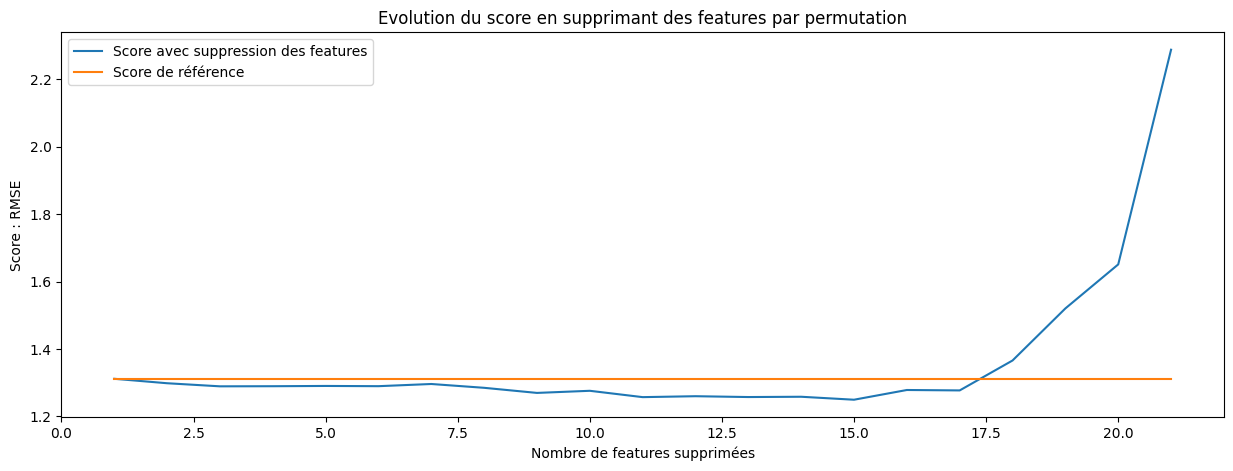

In [946]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.title('Evolution du score en supprimant des features par permutation')
sns.lineplot( x = graphe_features['index'].values,
            y = graphe_features["RMSE"])
sns.lineplot([1,graphe_features.shape[0]],[graphe_features.iloc[0,2], graphe_features.iloc[0,2]])
plt.xlabel('Nombre de features supprimées')
plt.ylabel('Score : RMSE')
plt.legend(['Score avec suppression des features',
           'Score de référence'])
ax = plt.gca()


plt.show()

Observations :
* On n'observe un minima local pour x = 12 (soit 12 features supprimées environs). On peut supprimer 18 features en améliorant un peu le modèle.
* on observe qu'on peut supprimer jusqu'à 17 features avec un impact marginal sur le score
* on observe que la suppression des 5 dernières features est particulièrement impactante


In [947]:
graphe_features['feature'].replace({
    'x0_' : 'BuildingType', 
    'x1_' : 'PrimaryPropertyType',
    'x2_' : 'Neighborhood',
    'x3_' : 'LargestPropertyUseType',
    'x4_' : 'SecondLargestPropertyUseType',
    'x5_' : 'ThirdLargestPropertyUseType', 
    'x6_' : 'Outlier'
}, inplace=True)

Le graphe ci-dessus peut être également affiché sous la façon suivante, en affichant le nom des features identifier leur importance relative

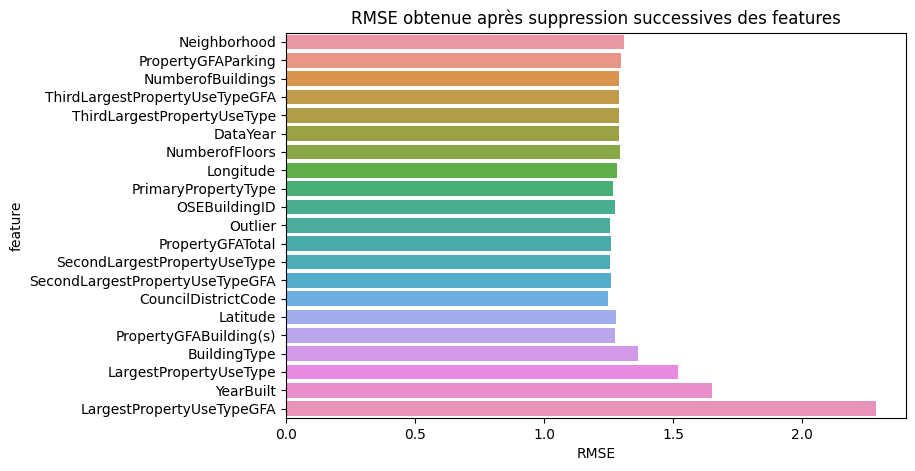

In [948]:
plt.figure(figsize=(8,5))
plt.title('RMSE obtenue après suppression successives des features')
sns.barplot(x = graphe_features['RMSE'],
           y = graphe_features['feature'])
plt.show()

### Bilan des permutations

Les résultats obtenus ci-dessus sont assez cohérents avec l'enjeu de la 
* les 2 features les plus significatives sont la surface dédiée à l'usage principal du bâtiment et son usage principal.
* La latitude a plus d'importance que la longitude. C'est peut être lié à la configuration de la ville, dont la distance nord sud est plus importante que la distance est-ouest (voir représentation cartographique dans l'analyse de données).
* certaines features sont d'importance moyenne : type de bâtiment, nombre de bâtiments, nombre d'étages 3ème type d'usage. 

Pour simplifier la collecte de données, on pourrait éventuellement réduire notre jeu de données aux features suivantes avec une dégradation minimale du score :
* LargestPropertyUseTypeGFA
* LargestPropertyUseType
* Numberoffloors
* Latitude
* Building Type

On ourrait aussi légèrement améliorer le modèle en supprimant les 5 features suivantes du jeu de données: 
* ThirdLargestPropertyUseType
* Longitude
* PrimaryPropertyType

## Méthode Ascendante

Contraire de la méthode par permutation : à chaque tour de boucle, on teste l'ajout d'une feature et on garde la feature qui améliore le plus le score. On boucle sur toutes les features jusqu'à toutes les avoir intégrées 

sur le principe la méthode fonctionne mais il faurait la reprendre avec les mêmes mises mise à jour que les permutations : cross validation et sélection par lot de features du one hot encoding

In [379]:
'''import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Boucle i sur le nombre de features:
    #boucle j sur le nombre de features:
        #fit du modèle avec i+1 features (feature pré sélectionnées + chaque feature 1 à 1) sur jeu de training
        #calcul du score sur jeu de test
    #on garde la feature j avec le plus petit score
    
#variables
X_train_ascend = pd.DataFrame(np.ones(X_train.shape[0]))
X_test_ascend = pd.DataFrame(np.ones(X_test.shape[0]))

#choix du modèle utilisé : 

#model = xgb_grid.best_estimator_
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

#définition des paramètres
list_features = list(range(X_test.shape[1])) #liste d'entiers
features_score_asc = []
features_kept = []
features_score = []

for i in list_features:
    scores = []
    features_left = list(set(list_features) - set(features_kept)) # liste d'entiers 
    print('features_left', len(features_left))
    for j in features_left:
        #on entraine le modèle avec la feature supplémentaire
        #print('X_train_ascend : ',X_train_ascend.shape)
        #print('X_train ', X_train.shape)
        #print('X_train.iloc[:,j] ', X_train.iloc[:,j].shape)
        #print('y_train ', y_train.shape)
        #print('concat : ', pd.concat([X_train_ascend,pd.DataFrame(X_train.iloc[:,j]).reset_index(drop=True)],axis=1).shape)
        
        
        model.fit(
            pd.concat(
                [X_train_ascend,
                 pd.DataFrame(X_train.copy().iloc[:,j]).reset_index(drop=True)
                ],axis=1),
            y_train)
        
        #on enregistre le score de ce modèle
        scores.append(
            math.sqrt(
                mean_squared_error(
                    model.predict(
                        pd.concat([X_test_ascend,
                                   pd.DataFrame(X_test.iloc[:,j]).reset_index(drop=True)
                                  ],axis=1)),
                    y_test)
            )
        )
        
        
    #sauvegarde de la feature et de son score
    features_score_asc.append(min(scores))
    feature_kept_index = scores.index(min(scores))
    features_kept.append(features_left[feature_kept_index]) #on enregistre la feature dans feature kept
    
    #mise à jour du jeu de données avec la feature supplémentaire
    X_train_ascend = pd.concat([X_train_ascend, 
                                pd.DataFrame(X_train.iloc[:, features_left[feature_kept_index]
                                                         ]).reset_index(drop=True)], axis=1)
    X_test_ascend  = pd.concat([X_test_ascend,
                                pd.DataFrame(X_test.iloc[:,  features_left[feature_kept_index]
                                                        ]).reset_index(drop=True)], axis=1)
    
    print('Tour {}. Feature ajoutée : {}. Score : {}'.format(i+1, features_kept[-1], features_score_asc[-1]))

asc_score = pd.DataFrame({'Feature' : features_kept,
                          'Score' : features_score_asc})'''

"import warnings\nwarnings.simplefilter(action='ignore', category=FutureWarning)\n\n#Boucle i sur le nombre de features:\n    #boucle j sur le nombre de features:\n        #fit du modèle avec i+1 features (feature pré sélectionnées + chaque feature 1 à 1) sur jeu de training\n        #calcul du score sur jeu de test\n    #on garde la feature j avec le plus petit score\n    \n#variables\nX_train_ascend = pd.DataFrame(np.ones(X_train.shape[0]))\nX_test_ascend = pd.DataFrame(np.ones(X_test.shape[0]))\n\n#choix du modèle utilisé : \n\n#model = xgb_grid.best_estimator_\nmodel = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=1, gamma=0,\n             importance_type='gain', learning_rate=0.1, max_delta_step=0,\n             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,\n             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,\n             reg_alpha=0, reg_lambda=1, scale_pos_weig

# Modèle Emissions

In [625]:
# y2 = data.copy()[{'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions' , 'Log2-SiteEnergyUseWN(kBtu)'}]
# X2 = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'], axis=1)

# Copier les colonnes sélectionnées dans un nouveau DataFrame y2
y2 = data.copy()[{ 'TotalGHGEmissions'}]

# Copier le DataFrame original et supprimer les colonnes spécifiées dans un nouveau DataFrame X2
X2 = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUseWN(kBtu)'], axis=1)


In [626]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ohe = OneHotEncoder(sparse=False)
# ss = StandardScaler()
# X2[numerical_columns] = ss.fit_transform(X2[numerical_columns])
# ohe.fit_transform(X2[categorical_columns])

# X2 = pd.merge(X[numerical_columns], 
#           pd.DataFrame(columns = ohe.get_feature_names().tolist(),
#               data = ohe.fit_transform(X2[categorical_columns])),
#         left_index = True, right_index = True)

# Importation des classes OneHotEncoder et StandardScaler depuis le module sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Création d'une instance de OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Création d'une instance de StandardScaler
ss = StandardScaler()

# Transformation des colonnes numériques de X2 en utilisant le StandardScaler
X2[numerical_columns] = ss.fit_transform(X2[numerical_columns])

# Entraînement du OneHotEncoder et transformation des colonnes catégoriques de X2
ohe.fit_transform(X2[categorical_columns])

# Fusion des colonnes numériques de X avec les colonnes encodées par OneHotEncoder
X2 = pd.merge(
    X[numerical_columns],
    pd.DataFrame(
        columns=ohe.get_feature_names().tolist(),
        data=ohe.fit_transform(X2[categorical_columns])
    ),
    left_index=True,
    right_index=True
)


OneHotEncoder et StandardScaler pour effectuer des transformations sur les données. Le StandardScaler est utilisé pour normaliser les colonnes numériques, tandis que le OneHotEncoder est utilisé pour encoder les colonnes catégoriques en utilisant la technique du "one-hot encoding". Les commentaires expliquent chaque étape du code et son objectif.

In [627]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = \
                        train_test_split(X2, 
                                         y2['TotalGHGEmissions'],  
                                         test_size = 0.3, 
                                         random_state = 42
                                        )


In [628]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}



In [629]:
rfr_emissions = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

rfr_emissions.fit(X_train2, y_train2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.7s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.5s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [630]:
model_emissions = rfr_emissions.best_estimator_

Export du modèle

In [631]:
filename = 'models/' + 'rfr_emissions' + '.obj' 
with  open(filename, 'wb') as filehandler :
    pickle.dump(model_emissions, filehandler)

In [632]:
math.sqrt(mean_squared_error(model_emissions.predict(X_test2), y_test2))

144.25027199727123

In [633]:
math.sqrt(mean_squared_error(model_emissions.predict(X_test2), y_test2))/y_test2.mean()

1.2065968624733818

23 % d'écart de la RMSE à la moyenne du jeu de test

In [634]:
selected_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Log2-(kBtu)']

d_corr = d_corr[selected_cols] 
d_corr

,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Log2-SiteEnergyUseWN(kBtu)
0,7.456910e+06,249.98,22.830147
1,8.664479e+06,295.86,23.046682
2,7.393711e+07,2089.28,26.139795
3,6.946800e+06,286.43,22.727917
4,1.465650e+07,505.01,23.805038
5,6.062768e+06,176.14,22.531545
6,1.419405e+07,392.16,23.758783
7,1.664693e+07,691.26,23.988753
8,2.707011e+07,740.97,24.690198
9,6.358720e+06,328.23,22.600305


<Axes: >

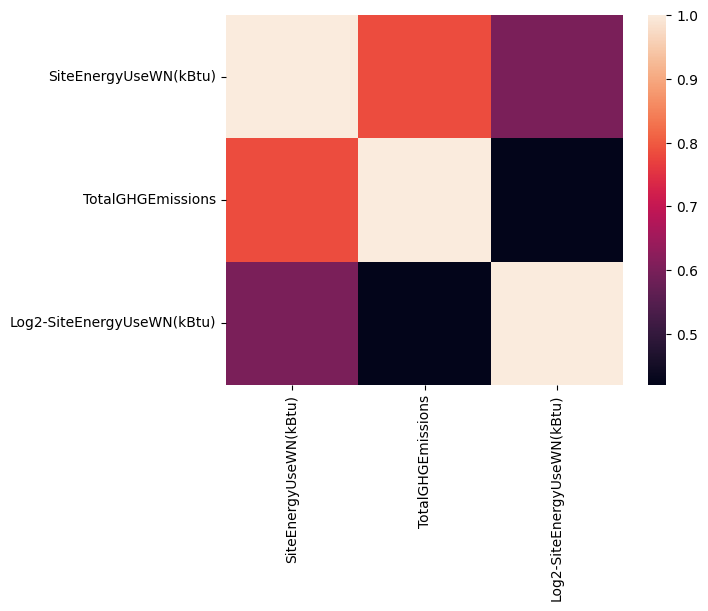

In [635]:
sns.heatmap(d_corr.corr())

On observe que les variables d'émissions et de consommation sont fortement corrélées (coefficient de 0,72). Voyons si nous pouvons entrainer un modèle d'estimation des émissions à partir de la sortie du modèle de prédiction des consommations

In [636]:
rfr_emissions_court = GridSearchCV(RandomForestRegressor(n_jobs=-1),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

In [637]:
rfr_emissions_court.fit(np.vstack([dict_modeles['Random Forest Regressor'].predict(X_train2), np.ones(X_train2.shape[0])]).T,
                          y_train2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   4.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [401]:
math.sqrt(mean_squared_error(rfr_emissions_court.best_estimator_.predict(
    np.vstack([dict_modeles['Random Forest Regressor'].predict(X_test2), np.ones(X_test2.shape[0])]).T),
                             y_test2))

167.68901825074352

La RMSE est quasiment égale que dans le cas du modèle avec toutes les features

Essayons en ajoutant en entrée du modèle de prédiction, la prédiction du modèle initial ainsi que les 5 features importantes du modèle initial, selon la permutation

In [409]:
data.head(1)

,index,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,Log2-SiteEnergyUseWN(kBtu)
0,0,1,2016,NonResidential,Residence/Hotel/Senior Care/Housing,7,DOWNTOWN,47.6122,-122.33799,1927,1.0,12,88434,0,88434,Residence/Hotel/Senior Care/Housing,88434.0,Other,0.0,Other,0.0,7456910.0,Normal,249.98,22.830147


In [403]:
columns_feature_emissions = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'x0_Campus', 'x0_Multifamily HR (10+)',
       'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)',
       'x0_NonResidential', 'x0_Nonresidential COS', 'x0_SPS-District K-12',
       'x1_Education', 'x1_Facility', 'x1_Health', 'x1_Leisure', 'x1_Office',
       'x1_Offices', 'x1_Other', 'x1_Residence/Hotel/Senior Care/Housing',
       'x1_Retail', 'x1_Storage', 'x1_Supermarket / Grocery Store',
       'x1_Warehouse', 'x2_Education', 'x2_Facility', 'x2_Health',
       'x2_Leisure', 'x2_Office', 'x2_Offices', 'x2_Other', 'x2_Parking',
       'x2_Residence/Hotel/Senior Care/Housing', 'x2_Retail', 'x2_Storage']
# ['LargestPropertyUseTypeGFA', 'x3_Education', 'x3_Facility', 'x3_Health',
#        'x3_Leisure', 'x3_Office', 'x3_Offices', 'x3_Other', 'x3_Parking',
#        'x3_Personal Services (Health/Beauty, Dry Cleaning, etc)',
#        'x3_Residence/Hotel/Senior Care/Housing', 'x3_Retail', 'x3_Storage', 
#                             'NumberofFloors', 'Latitude', 'x0_Campus', 'x0_Multifamily HR (10+)',
#        'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)',
#        'x0_NonResidential', 'x0_Nonresidential COS', 'x0_Nonresidential WA',
#        'x0_SPS-District K-12']


In [404]:
dict_modeles['Random Forest Regressor'].predict(X_train2).reshape(-1,1).shape

(676, 1)

In [411]:
columns_feature_emissions = X_train2.columns
columns_feature_emissions

Index(['index', 'OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'x0_NonResidential',
       'x0_Nonresidential COS', 'x1_Education', 'x1_Facility', 'x1_Health',
       'x1_Leisure', 'x1_Office', 'x1_Offices', 'x1_Other',
       'x1_Residence/Hotel/Senior Care/Housing', 'x1_Retail', 'x1_Storage',
       'x1_Supermarket / Grocery Store', 'x1_Warehouse', 'x2_BALLARD',
       'x2_CENTRAL', 'x2_DELRIDGE', 'x2_DOWNTOWN', 'x2_EAST',
       'x2_GREATER DUWAMISH', 'x2_LAKE UNION', 'x2_MAGNOLIA / QUEEN ANNE',
       'x2_NORTH', 'x2_NORTHEAST', 'x2_NORTHWEST', 'x2_SOUTHEAST',
       'x2_SOUTHWEST', 'x3_Education', 'x3_Facility', 'x3_Health',
       'x3_Leisure', 'x3_Office', 'x3_Offices', 'x3_Other', 'x3_Parking',
       'x3_R

In [412]:
X_train2[columns_feature_emissions].shape

(676, 80)

In [413]:
rfr_emissions_court2 = GridSearchCV(RandomForestRegressor(n_jobs=-1),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

rfr_emissions_court2.fit(np.hstack([dict_modeles['Random Forest Regressor'].predict(X_train2).reshape(-1,1), X_train2[columns_feature_emissions].to_numpy()]),
                          y_train2)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   3.8s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   0.5s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.3s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [624]:
math.sqrt(mean_squared_error(rfr_emissions_court2.predict(
    np.hstack([dict_modeles['Random Forest Regressor'].predict(X_test2).reshape(-1,1), 
               X_test2[columns_feature_emissions].to_numpy()])),y_test2))

238.01362410236806

Ce résultat est très satisfaisant : la RMSE est encore plus faible que pour le modèle entraîné initialement sans la consommation.

Export du modèle

In [784]:
filename = 'models/' + 'rfr_emissions' + '.obj' 
with  open(filename, 'wb') as filehandler :
    pickle.dump(rfr_emissions_court2, filehandler)

ValueError: X has 80 features, but RandomForestRegressor is expecting 77 features as input.

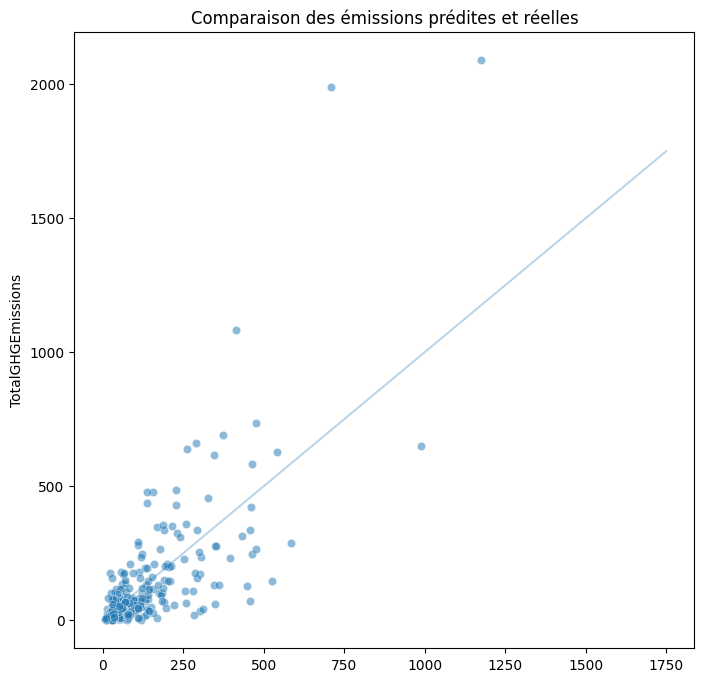

In [785]:
plt.figure(figsize=(8,8))
plt.title('Comparaison des émissions prédites et réelles')
sns.lineplot(x = [0,1750], y = [0,1750], alpha=0.3)
sns.scatterplot(x = model_emissions.predict(X_test2),
                y = y_test2, alpha=0.5)
sns.scatterplot(x = rfr_emissions_court2.predict(np.hstack([dict_modeles['Random Forest Regressor'].predict(X_test2).reshape(-1,1), 
               X_test2[columns_feature_emissions].to_numpy()])),
                y = y_test2, alpha=0.5)
plt.legend(['ligne x=y', 'modèle classique,', 'modèle simplifié'])
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

# Intérêt du Energy Star Score

Entrainons un nouveau modèle avec le Energy Star Score

In [605]:
X_en = X.copy()

In [606]:
X_en['energy_star_score'] = energy_star_score

In [609]:
y_en = y['Log2-SiteEnergyUseWN(kBtu)'].copy()
y_en.drop(X_en[X_en['energy_star_score'].isna()].index, inplace=True)
# y_en = y['SiteEnergyUseWN(kBtu)'].copy()
# y_en.drop(X_en[X_en['energy_star_score'].isna()].index, inplace=True)

In [610]:
X_en.drop(X_en[X_en['energy_star_score'].isna()].index, inplace=True)

In [611]:
from sklearn.model_selection import train_test_split
X_en_train, X_en_test, y_en_train, y_en_test = \
                        train_test_split(X_en, 
                                         y_en,  
                                         test_size = 0.2, 
                                         random_state = 42
                                        )


In [612]:
model_en = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

model_en.fit(X_en_train, y_en_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.8s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   2.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.7s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.9s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.8s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.6s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [613]:
math.sqrt(mean_squared_error(model_en.predict(X_en_test), y_en_test))

0.7606373241736416

Entrainons un autre modèle avec les mêmes données sans le Energy Star Score

In [614]:
X_en_train.drop(['energy_star_score'], axis=1, inplace=True)
X_en_test.drop(['energy_star_score'], axis=1, inplace=True)

In [615]:
model_en = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

model_en.fit(X_en_train, y_en_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.9s
[CV] END max_

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.6s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.6s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   1.7s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; tot

[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.8s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.7s
[CV] END max_features=sqrt, min_samples_leaf=10, n_estimators=500; total time=   0.7s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [616]:
math.sqrt(mean_squared_error(model_en.predict(X_en_test), y_en_test))

0.8158460435013714

In [617]:
math.sqrt(mean_squared_error(model_en.predict(X_en_test), y_en_test))

0.8158460435013714

Le résultat obtenu ici avec le Energy Star Score est bien moins bon que le modèle initial, où on avait davantage de données (1500 obsevations supplémentaires). On voit cependant qu'à iso échantillon, le Energy Star Score améliore très légèrement la performance et semble donc pertinent . Cependant, dans la mesure où:
* il est manquant pour un certain nombre de données de l'échantillon (et donc potentiellement des futurs bâtiments pour lesquels il faudra faire tourner le modèle)
* il est fastidieux à calculer

On peut tout à fait se passer du Energy Star Score au prix d'un modèle légèrement moins précis (cf parties précédentes du notebook) mais avec une complexité moindre pour l'ensemble du processus. Dans le cas où les équipes parviendraient à estimer de façon simple le Energy Star Score, la question serait à reconsidérer et il serait alors pertinent de l'intégrer au modèle

# Fonction de prédiction complète

NB : pour préparer le fichiµer avant prédiction, voir notebook "nettoyage_analyse"

Le jeu final retenu pour le modèle de consommation est le Random Forest Regressor entraîné sur toutes les features et avec les paramètres suivants: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
Le jeu final retenu pour le modèle émissions est en random forest regressor entraîné sur le jeu de données réduit (voir partie associée)

In [620]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import pickle



def prediction_from_scratch(file_path, model_path = './models/'):
    '''Chargement et application du modèle de prédiction à un jeu de données spécifique, 
    à partir du .csv du jeu de données
    
    NB : le jeu de données devra avoir été préalablement nettoyé par application de la 
    fonction import_clean à la fin du notebook de nettoyage et d'analyse.

    Paramètres : 
    * file_path : chemin tu fichier .csv
    * model_path : répertoire des modèles 

    Retour : consommation du site (en kBtu) et émissions '''

    #préparation des données
    try:
        dataframe = pd.read_csv(file_path)
    except:
        print('Erreur dans le chargement des données')
    print(dataframe.columns)
    print(dataframe.dtypes)
    #préparation des features:

    colonnes = ['index', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'Outlier',
       'Latitude', 'Longitude']
    
#     columns_feature_emissions = ['LargestPropertyUseTypeGFA', 'x3_Education', 'x3_Facility', 'x3_Health',
#        'x3_Leisure', 'x3_Office', 'x3_Offices', 'x3_Other', 'x3_Parking',
#        'x3_Personal Services (Health/Beauty, Dry Cleaning, etc)',
#        'x3_Residence/Hotel/Senior Care/Housing', 'x3_Retail', 'x3_Storage', 
#                             'NumberofFloors', 'Latitude', 'x0_Campus', 'x0_Multifamily HR (10+)',
#        'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)',
#        'x0_NonResidential', 'x0_Nonresidential COS', 'x0_Nonresidential WA',
#        'x0_SPS-District K-12']
    columns_feature_emissions = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'x0_Campus', 'x0_Multifamily HR (10+)',
       'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)',
       'x0_NonResidential', 'x0_Nonresidential COS', 'x0_SPS-District K-12',
       'x1_Education', 'x1_Facility', 'x1_Health', 'x1_Leisure', 'x1_Office',
       'x1_Offices', 'x1_Other', 'x1_Residence/Hotel/Senior Care/Housing',
       'x1_Retail', 'x1_Storage', 'x1_Supermarket / Grocery Store',
       'x1_Warehouse', 'x2_Education', 'x2_Facility', 'x2_Health',
       'x2_Leisure', 'x2_Office', 'x2_Offices', 'x2_Other', 'x2_Parking',
       'x2_Residence/Hotel/Senior Care/Housing', 'x2_Retail', 'x2_Storage']
    colonnes_choisi = [ 'YearBuilt', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA']
# 'PropertyGFATotal': Superficie totale du bien immobilier (en pieds carrés)
# 'PropertyGFAParking': Superficie de stationnement du bien immobilier (en pieds carrés)
# 'PropertyGFABuilding(s)': Superficie du bâtiment(s) du bien immobilier (en pieds carrés)
# 'LargestPropertyUseType': Type d'utilisation principal le plus important
# 'LargestPropertyUseTypeGFA': Superficie d'utilisation principale la plus importante (en pieds carrés)
    X = dataframe.copy()[colonnes]

    #chargement des modèles
    dict_modeles_prediction = {}
    for filename in glob.glob(str(model_path + '*')):
        with open(filename, 'rb') as filehandler:
            if 'onehotencoder.obj' in filename:
                onehotencoder = pickle.load(filehandler)
                
            elif 'standardscaler.obj' in filename:
                ss = pickle.load(filehandler)
            else:
                dict_modeles_prediction[filename] = pickle.load(filehandler)
                if 'Random Forest Regressor.obj' in filename:
                    modele_consommation = dict_modeles_prediction[filename]
                elif 'rfr_emissions.obj' in filename:
                    modele_emissions = dict_modeles_prediction[filename]
    
    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.select_dtypes(['int64', 'float32','int32','float64']).columns
    print(numerical_columns)
    print(X.dtypes)
    X[colonnes_choisi] = ss.transform(X[colonnes_choisi])
    onehotencoder.transform(X[categorical_columns])
#     X = onehotencoder.fit_transform(X[categorical_columns])


    X = pd.merge(X[numerical_columns], 
              pd.DataFrame(columns = onehotencoder.get_feature_names().tolist(),
                  data = onehotencoder.transform(X[categorical_columns])),
            left_index = True, right_index = True)
    regex = re.compile(r'x\d_')
    for column in X.columns:
        if regex.search(column):
            X[column] = X[column].astype('int32')

    #application des 2 modèles
    #   prédiction consommations
    consommation = modele_consommation.predict(X)
    #   dénormalisation : application np.exp2
    consommation = np.exp2(consommation)
    #prédiction émissions
    emissions = modele_emissions.predict(np.hstack([modele_consommation.predict(X).reshape(-1,1), 
               X[columns_feature_emissions].to_numpy()]))
    
    return pd.DataFrame(list(zip(consommation, emissions)), columns=['Consommation', 'Emissions'], index = X.index)

In [621]:
prediction_from_scratch('data/data_cleaned.csv')

Index(['index', 'OSEBuildingID', 'DataYear', 'BuildingType',
       'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'Log2-SiteEnergyUseWN(kBtu)'],
      dtype='object')
index                              int64  
OSEBuildingID                      int64  
DataYear                           int64  
BuildingType                       object 
PrimaryPropertyType                object 
CouncilDistrictCode                int64  
Neighborhood                       object 
Latitude                           float64
Longitude

ValueError: X has 5 features, but StandardScaler is expecting 15 features as input.

In [148]:
pd.read_csv('data/data_cleaned - reduit_5L.csv')

,index,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),Outlier,Latitude,Longitude,TotalGHGEmissions,Log2-SiteEnergyUseWN(kBtu)
0,0,2015,NonResidential,Residence/Hotel/Senior Care/Housing,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Residence/Hotel/Senior Care/Housing,88434.0,Other,0.0,Other,0.0,65.0,7097539.0,Normal,47.612190,-122.337997,249.43,22.758888
1,5,2015,Nonresidential COS,Other,7,DOWNTOWN,1999,1.0,2.0,97288,37198,60090,Offices,88830.0,Other,0.0,Other,0.0,NaN,13045258.0,Normal,47.616439,-122.336764,304.62,23.637022
2,6,2015,NonResidential,Residence/Hotel/Senior Care/Housing,7,DOWNTOWN,1926,1.0,11.0,83008,0,83008,Residence/Hotel/Senior Care/Housing,81352.0,Other,0.0,Other,0.0,25.0,6477493.0,Normal,47.614114,-122.332741,208.46,22.627004
3,7,2015,NonResidential,Other,7,DOWNTOWN,1926,1.0,8.0,102761,0,102761,Leisure,102761.0,Other,0.0,Other,0.0,NaN,7380086.0,Normal,47.612902,-122.331309,199.99,22.815206
4,8,2015,NonResidential,Residence/Hotel/Senior Care/Housing,7,DOWNTOWN,1904,1.0,15.0,163984,0,163984,Residence/Hotel/Senior Care/Housing,163984.0,Other,0.0,Other,0.0,46.0,13589025.0,Normal,47.602589,-122.332553,331.61,23.695939


 # Complément : Assemblage de modèles

En bonus sur ce qui est attendu pour ce projet :
Régression linéaire pour faire une prédiction à partir de l'ensemble des prédictions obtenues par les différents modèles

In [687]:
dict_modeles.keys()

dict_keys(['Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost', 'models\\Elastic Net.obj', 'models\\Random Forest Regressor.obj', 'models\\rfr_emissions.obj', 'models\\SVM.obj', 'models\\XGBoost.obj'])

In [688]:
dict_modeles_final = {k: v for k, v in dict_modeles_new.items() if k in ['models\\Elastic Net.obj', 
                                                                         'models\\Random Forest Regressor.obj',
                                                                         'models\\SVM.obj', 
                                                                         'models\\XGBoost.obj']}

In [689]:
dict_modeles_final['XGBOOST'] = xgb_grid.best_estimator_

In [690]:
dict_modeles_final.keys()

dict_keys(['models\\Elastic Net.obj', 'models\\Random Forest Regressor.obj', 'models\\SVM.obj', 'models\\XGBoost.obj', 'XGBOOST'])

In [691]:
dict_modeles_final['XGBOOST'].feature_importances_

array([1.59020871e-02, 1.70704734e-03, 0.00000000e+00, 3.94691294e-03,
       1.42310243e-02, 2.17900742e-02, 1.38232363e-02, 6.31570863e-03,
       2.52627172e-02, 6.04428649e-02, 2.66063423e-03, 3.82202864e-02,
       5.51936924e-02, 1.68788899e-02, 0.00000000e+00, 0.00000000e+00,
       4.70868777e-03, 1.40420103e-03, 1.33840615e-04, 9.62322764e-03,
       2.54056999e-03, 3.82394195e-02, 9.13714245e-03, 1.19086057e-02,
       1.99485850e-02, 1.64757445e-02, 0.00000000e+00, 9.68938693e-03,
       3.13308239e-02, 3.28207185e-04, 6.17844379e-03, 8.14305898e-03,
       1.07385702e-01, 1.72117110e-02, 2.13482161e-03, 4.63844556e-03,
       3.52250598e-03, 1.03524583e-03, 5.23809250e-03, 1.66308507e-02,
       4.76873806e-03, 1.30824288e-02, 1.22599425e-02, 1.12410402e-02,
       9.81351137e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.57883428e-02, 0.00000000e+00, 0.00000000e+00, 2.26014834e-02,
       0.00000000e+00, 4.48077545e-03, 0.00000000e+00, 4.51935232e-02,
      

In [692]:
del dict_modeles_final['models\\XGBoost.obj']

In [693]:
import math

In [694]:
from sklearn.linear_model import Ridge
from sklearn.utils import resample

X_final_train = pd.DataFrame()
X_final_test = pd.DataFrame()

liste_resultats_modeles = {}
for key, modele_charge in dict_modeles_final.items():
    liste_score = []
    print(key)
    
    X_final_train2 = pd.DataFrame(modele_charge.predict(X_train), columns = [key])
    X_final_test2 = pd.DataFrame(modele_charge.predict(X_test), columns=[key])
    
    
    if X_final_train.empty :
        X_final_train = X_final_train2
        X_final_test = X_final_test2
    else:
        X_final_train = pd.concat((X_final_train, X_final_train2), axis=1)
        X_final_test  = pd.concat((X_final_test , X_final_test2 ), axis=1)
        
    print(X_final_train.shape)
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
ridge = GridSearchCV(estimator = Ridge(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

ridge.fit(X_final_train, y_train)

print('RMSE finale : ', math.sqrt(mean_squared_error(ridge.best_estimator_.predict(X_final_test), y_test)))


models\Elastic Net.obj
(745, 1)
models\Random Forest Regressor.obj
(745, 2)
models\SVM.obj
(745, 3)
XGBOOST
(745, 4)
RMSE finale :  2.0614145340030134


On obtient une RMSE finale de 0,6300, très légèrement inférieure à la valeur obtenut avec Random Forest (0,6304), le modèle final peut donc être légèrement amélioré en intégrant cette prédiction, au prix d'une complexité supplémentaire.

In [695]:
print(X_final_train.columns)

Index(['models\Elastic Net.obj', 'models\Random Forest Regressor.obj',
       'models\SVM.obj', 'XGBOOST'],
      dtype='object')


In [696]:
importance_modeles = pd.DataFrame({'modele' : X_final_train.columns,
              'coefficient (abs)' :  abs(ridge.best_estimator_.coef_)})

In [697]:
# import pandas as pd
# import numpy as np

# # Aplatir la colonne X_final_train.columns
# flattened_columns = np.array(X_final_train.columns).flatten()

# # Créer le DataFrame avec les colonnes aplaties
# importance_modeles = pd.DataFrame({'modele': flattened_columns,
#                                    'coefficient (abs)': abs(ridge.best_estimator_.coef_)})


<Axes: title={'center': 'Importance des modèles dans la fonction de décision finale'}, xlabel='modele', ylabel='coefficient (abs)'>

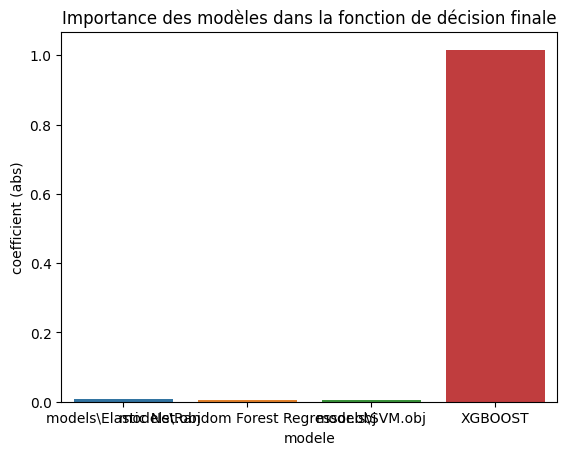

In [698]:
plt.title('Importance des modèles dans la fonction de décision finale')
sns.barplot(x = importance_modeles['modele'],
           y = importance_modeles['coefficient (abs)'])

#  Complément : Bootstrap

Reprendre le bootstrap pour avoir un élément de confiance dans la prédiction : on espère que plus l'erreur est grande plus la variance des prédictions obtenues par bootstrap est grande. Ce qui apporte beaucoup d'informations.

In [699]:
from sklearn.ensemble import RandomForestRegressor
scores = []
model_bootstrap = []
y_pred = []
yvar = []
for i in range(100):
    print('Echantillon ',i+1)
    #on choisit un échantillon bootstrap de l'ensemble du frame
    X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, 
                                                        replace=True, n_samples = X_train.shape[0])
    #instanciation du modèle
    model_bootstrap.append(RandomForestRegressor(n_jobs = -1, 
                                            max_features = 'sqrt', 
                                            min_samples_leaf = 1,
                                            n_estimators = 500))
    
    model_bootstrap[-1].fit(X_train_bootstrap, y_train_bootstrap)
    
    y_pred.append(model_bootstrap[-1].predict(X_test))
    scores.append(y_pred[i] - y_test.iloc[i])

y_pred = np.array(y_pred)
scores = np.array(scores)
var = []
score = []
for i in range(y_pred.shape[0]):
    var.append(np.var(y_pred[i,:]))
    score.append(np.mean(scores[i,:]))

Echantillon  1
Echantillon  2
Echantillon  3
Echantillon  4
Echantillon  5
Echantillon  6
Echantillon  7
Echantillon  8
Echantillon  9
Echantillon  10
Echantillon  11
Echantillon  12
Echantillon  13
Echantillon  14
Echantillon  15
Echantillon  16
Echantillon  17
Echantillon  18
Echantillon  19
Echantillon  20
Echantillon  21
Echantillon  22
Echantillon  23
Echantillon  24
Echantillon  25
Echantillon  26
Echantillon  27
Echantillon  28
Echantillon  29
Echantillon  30
Echantillon  31
Echantillon  32
Echantillon  33
Echantillon  34
Echantillon  35
Echantillon  36
Echantillon  37
Echantillon  38
Echantillon  39
Echantillon  40
Echantillon  41
Echantillon  42
Echantillon  43
Echantillon  44
Echantillon  45
Echantillon  46
Echantillon  47
Echantillon  48
Echantillon  49
Echantillon  50
Echantillon  51
Echantillon  52
Echantillon  53
Echantillon  54
Echantillon  55
Echantillon  56
Echantillon  57
Echantillon  58
Echantillon  59
Echantillon  60
Echantillon  61
Echantillon  62
Echantillon  63
E

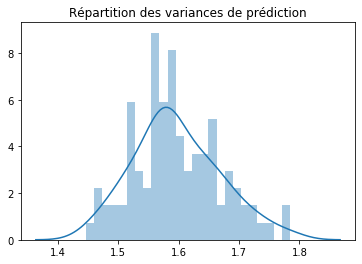

In [157]:
plt.title('Répartition des variances de prédiction')
sns.distplot(var, bins = 25)

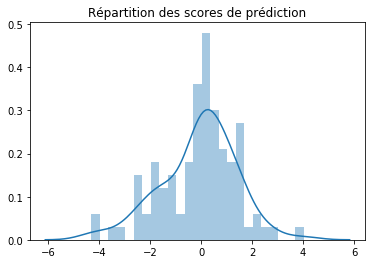

In [158]:
plt.title('Répartition des scores de prédiction')
sns.distplot(score, bins = 25)

In [167]:
for i, el in enumerate(score):
    score[i] = abs(el)

Text(0, 0.5, 'variance')

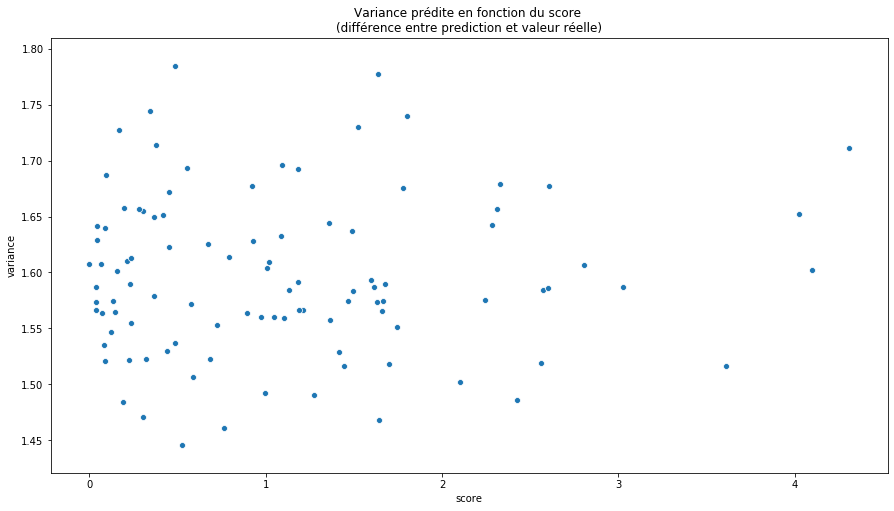

In [168]:
plt.figure(figsize=(15,8))
plt.title('Variance prédite en fonction du score \n(différence entre prediction et valeur réelle)')
sns.scatterplot(x = score, y = var)
plt.xlabel('score')
plt.ylabel('variance')

In [175]:
np.corrcoef(score , var)

array([[1.        , 0.04422661],
       [0.04422661, 1.        ]])

In [327]:
# Chargement des données
df = pd.read_csv('data/data_cleaned.csv')

In [328]:
df.dtypes

index                              int64  
OSEBuildingID                      int64  
DataYear                           int64  
BuildingType                       object 
PrimaryPropertyType                object 
CouncilDistrictCode                int64  
Neighborhood                       object 
Latitude                           float64
Longitude                          float64
YearBuilt                          int64  
NumberofBuildings                  float64
NumberofFloors                     int64  
PropertyGFATotal                   int64  
PropertyGFAParking                 int64  
PropertyGFABuilding(s)             int64  
LargestPropertyUseType             object 
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType       object 
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType        object 
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEnergyUseWN(kBtu)              float64
Outlier    

In [329]:
print(df.columns)

Index(['index', 'OSEBuildingID', 'DataYear', 'BuildingType',
       'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'Log2-SiteEnergyUseWN(kBtu)'],
      dtype='object')


In [330]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Chargement des données
df = pd.read_csv('data/data_cleaned.csv')

# Vérification de la présence de la colonne 'TotalGHGEmissions'
if 'TotalGHGEmissions' not in df.columns:
    raise ValueError("La colonne 'TotalGHGEmissions' est introuvable dans le jeu de données")

# Suppression des colonnes inutiles pour la prédiction
# df.drop(['OSEBuildingID', 'DataYear', 'PropertyName', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier'], axis=1, inplace=True)

# Traitement des variables catégorielles avec OneHotEncoder
cat_cols = [col for col in df.columns if df[col].dtype in ['object', 'category']]
print(cat_cols)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Traitement des variables numériques avec StandardScaler
num_cols = [col for col in df.columns if df[col].dtype in ['int8', 'float32','int64', 'float64']]
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Préparation du préprocesseur
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cols),
    ('num', num_transformer, num_cols)
])

# Préparation des données pour l'apprentissage
df = df.reset_index(drop=True) # resynchroniser les index
# y = df['TotalGHGEmissions']
# X = df.drop('TotalGHGEmissions', axis=1)
print(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition des modèles à tester avec GridSearchCV
models = [
    {
        'name': 'LinearRegression',
        'estimator': LinearRegression(),
        'hyperparameters': {}
    },
    {
        'name': 'Lasso',
        'estimator': Lasso(),
        'hyperparameters': {
            'alpha': [0.1, 1, 10]
        }
    },
    {
        'name': 'Ridge',
        'estimator': Ridge(),
        'hyperparameters': {
            'alpha': [0.1, 1, 10]
        }
    },
    {
        'name': 'RandomForestRegressor',
        'estimator': RandomForestRegressor(),
        'hyperparameters': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None]
        }
    }
]

# Entraînement et évaluation des modèles avec GridSearchCV et cross-validation
for model in models:
    print(f"Training {model['name']}...")
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model['estimator'])
    ])
    grid = GridSearchCV(pipe, model['hyperparameters'], cv=5, scoring='r2')
    scores = cross_val_score(grid, X_train, y_train, cv=5, scoring='r2')
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Training R2 score: {grid.score(X_train, y_train):.4f}")
    print(f"Test R2 score: {grid.score(X_test, y_test):.4f}")

['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Outlier']
     YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0   -1.149233  -0.020513           1.516661       -0.028003           
1    0.199175  -0.020513           6.873033        7.457116           
2   -1.181338  -0.020513           1.147256       -0.261906           
3   -1.181338  -0.020513           1.331958       -0.074811           
4   -1.887647  -0.020513           2.070768        0.623739           
5    0.199175  -0.020513           1.331958        0.530390           
6    1.130218  -0.020513           3.917793        2.083295           
7   -1.117128  -0.020513           0.962554       -0.230082           
8    0.552329  -0.020513           5.395413        1.934710           
9   -1.309758  -0.020513           1.331958        0.004398           
10   0.648644  -0.020513           4.471900        2.800211    

Training LinearRegression...


ValueError: A given column is not a column of the dataframe